# Map Zone Labelling

**Goals**:
- map zone labels
- remove some low quality cells

---

**ATTENTION**:
- mapping heppens for a single cell type: need to have all cells of a spefic cell type and get zone lebels for them (thus use a the corresponding cell type reference)
- Query must:
    - have same gene names --> "gene symbols" (not ensamble id)
    - be .h5ad
    - have raw counts in .X
- outputs
    - recomputed_stats.h5: Reference statistics per cell type
    - reference_markers.h5: Marker genes for reference cell types
q   - query_markers.json: Selected markers for query mapping ("markers useful for querying" not "based on a specific query dataset.")
    - **mapping_output.csv**: CSV table with:
        - Cell barcodes/IDs
        - Predicted cell type labels
        - Confidence/probability scores

The script to run mapmycell on this dataset works by:
- Computing statistics from a reference (annotated) dataset
- Finding marker genes
- Mapping query cells to reference cell types using those markers

In [1]:
%load_ext autoreload
%autoreload 2


# MUST BE FIRST - before any imports from cell_type_mapper --> error if FromSpecifiedMarkersRunner run wiht GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import pandas as pd
import scanpy as sc
import os
from dotenv import load_dotenv; load_dotenv()
import ipynbname
import shutil
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm.notebook import tqdm
import subprocess
import shutil
from scipy import sparse


from utils import preprocessing


# Hyperparamyters
BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
DISEASE_TYPE = "diseased" # diseased / healthy
SAMPLE_ID = "recon_241105" #"sample_01" #"recon_241105"

ADATA_PATH = f'{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/adata/all_lib_adata_cell_type_MSN_QCed.h5ad' #"/home/gdallagl/myworkdir/XDP/data/XDP/diseased/recon_241105/FAKE_BCL/FAKE_LIBRARY/adata/reprocessed_filtered_adata.h5ad" #f'{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/adata/all_lib_adata.h5ad'
MAPPING_OUTPUT_FOLDER =  f'{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/zoning'
FINAL_ADATA_PATH = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/adata/all_lib_adata_zoned.h5ad"

ZONE_LABELLING_SCRIPT = os.getenv("ZONE_LABELLING_SCRIPT") # bash script that maps
ZONE_LABELLING_REFERENCES_FOLDER = os.getenv("ZONE_LABELLING_REFERENCES_FOLDER") # where the bican refecnes for zone mapping are stored
ZONE_LABELLING_STAT_FOLDER = f"{ZONE_LABELLING_REFERENCES_FOLDER}/stats" # temp folder to save stast needed for mapping

# obs col in the refereces adata that contains the zone labels for mappign
ZONE_LABELS_COL_NAME_IN_REF = "harmony_clusters"# "D1_zones_6_assigned_v2" #ATTENTION: must be the same of the mapping scirpt

# cell classigcation in .json to use as gourping  for mapping 
CT_GROUPING_TO_MAP = "mapping_coupling_for_zoning"

OBS_COL_ZONE = "zone" # col where zone will be saved

In [8]:
# ONLY IF YOU WANT TO SPECIFIY

if True:
    ADATA_PATH = f"/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_labelled.h5ad"
    FINAL_ADATA_PATH = f"{os.path.splitext(ADATA_PATH)[0]}_zoned.h5ad"
    print(FINAL_ADATA_PATH)

    # paths to files where mapping output will be written
    os.makedirs(f"{os.path.split(ADATA_PATH)[0]}/zoning", exist_ok=True)

    # ATTENTION; need speciufuc mapping
    # query.layers["counts"] = query.X.copy()
    # query.var["gene_symbol"] = query.var.index
    # import scipy.sparse as sp
    # query.X = sp.csr_matrix(query.shape)

/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_labelled_zoned.h5ad


# Only once: download and preprocess the adata reference for mapping

Need to have zone-mapping label col AND raw counts.

```bash
    # Downlaod locally
    gsutil -m cp  gs://macosko_data/leematth/sharing/for_gabri/*  . 
```

In [2]:
# # Minimize adatas reference

# folder="/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad"

# for path in [os.path.join(folder, f) for f in os.listdir(folder) if not os.path.isdir(os.path.join(folder, f))]:

#     print(path)

#     a = sc.read_h5ad(path)#, backed="r")
#     print(a)


#     # is raw counts
#     frac = np.count_nonzero(a.X.data % 1 != 0) / a.X.size
#     print("Fractional values ratio:", frac)

#     # has zone col
#     print("Has zone col: ", ZONE_LABELS_COL_NAME_IN_REF in list(a.obs.columns))

#     # Which value sin zone col
#     print("Zone Values: ", list(a.obs[ZONE_LABELS_COL_NAME_IN_REF].unique()))

#     adata_minimal = sc.AnnData(
#         X=sparse.csr_matrix(a.X),
#         obs=a.obs.copy(),
#         var=a.var.copy()
#     )

#     # Remove cells with Nan in zone col
#     adata_minimal = adata_minimal[~ adata_minimal.obs[ZONE_LABELS_COL_NAME_IN_REF].isna()]

#     adata_minimal.write(path)

#     print("\n")

# del a, adata_minimal

# Load Query


In [10]:
query = sc.read_h5ad(ADATA_PATH)
print(query)

AnnData object with n_obs × n_vars = 606390 × 38601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'barcode', 'bcl', 'rna_index', 'library', 'library__barcode', 'frac_mito', 'mol_info_nUMI', 'mol_info_nRead', 'frac_intronic', 'donor_id', 'vireo_prob_max', 'vireo_prob_doublet', 'vireo_n_vars', 'vireo_best_singlet', 'vireo_best_doublet', 'vireo_doublet_logLikRatio', 'dropsift_frac_contamination', 'dropsift_training_label_is_cell', 'dropsift_empty_gene_module_score', 'dropsift_is_cell', 'dropsift_is_cell_prob', 'cell_class', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'tissue', 'broad_original_cell_type', 'Neighborhood_label', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Neighborhood_correlation_coefficient', 'Class_label', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Class_correlation_coefficient', 'Subclass_label', 'Subclass_name'

In [ ]:
# Create spatial matrix with NaN by default
spatial_coords = np.full((query.n_obs, 2), np.nan)
# For cells with has_spatial == True, add their real coordinates
mask = query.obs['has_spatial'] == True
spatial_coords[mask] = query.obs.loc[mask, ['x', 'y']].values
# Assign to obsm
query.obsm['spatial'] = spatial_coords

### Add cell type groups for mapping


KeyError: "Could not find 'spatial' or 'X_spatial' in .obsm"

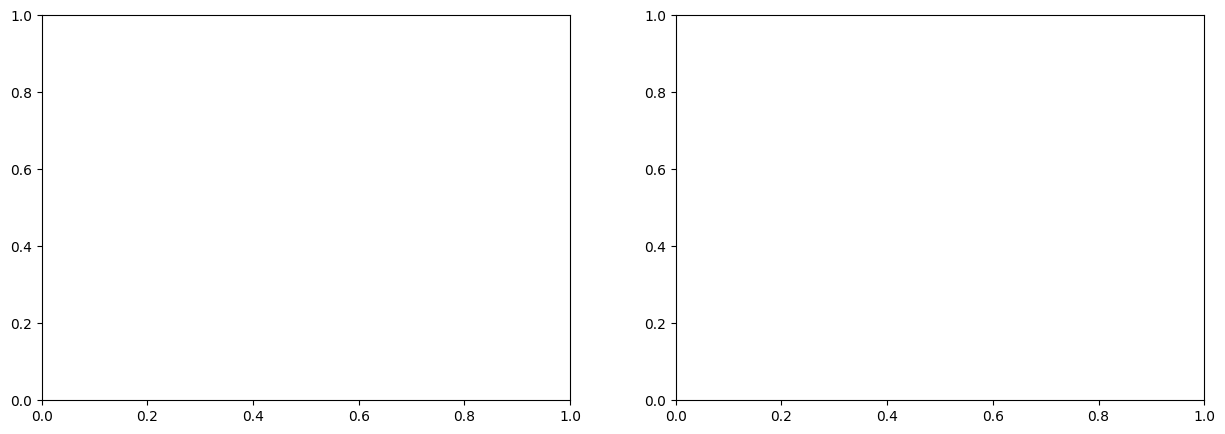

In [11]:
# Load the JSON file
with open(os.getenv("GROUP_LEVEL_MMC_MAPPING_PATH"), 'r') as f:
    classifications = json.load(f)

schemes = [CT_GROUPING_TO_MAP]

for classification in schemes:
    # Filter out annotation entries (those with keys starting with "_
    clean_mapping = {
        k: v for k, v in classifications[classification].items() 
        if not k.startswith("_")
    }    
    # Apply classification
    query.obs[classification] = query.obs['Group_name'].map(clean_mapping)


for i, res in enumerate(schemes):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sc.pl.embedding(query, basis="spatial", color=res, ax=axes[0], show=False, legend_loc=None, size=20, palette=sc.pl.palettes.vega_10  ) #     # First plot will generate colors and store them in adata.uns[f'{res}_colors']
    sc.pl.umap(query, color=res, ax=axes[1], show=False)#, legend_loc="on data") #    # Second plot will automatically use the same colors from adata.uns


    plt.tight_layout()
    plt.show()

# Define a cell type mapping

Each query cell type ("Group_name level) need to be mapped against the corresponding cell type in the referece (ie the name of the h5ad file used for mapping that cell type).

ATTENTION: multiple cell type can be mapped to the same referece cell type (h5ad file).

In reality the link is already created/writtein in the file `utils/STR_cell_types_annotation/group_level_mmc_mapping.json` in the col `mapping_coupling_for_zoning`.

Here we do not define the link (as alredy defined in that file), but write a dict where the:
- keys --> names cell types used for referece
- items --> keys with "_", ie the name to use for retrive the paths of the h5ad.

TO do this, we juts use the mapping in .json and add "_" in values.
ATTENTION: the keys are the referece adata names witiuhu "_".

In [12]:
# Filter out annotation entries (those with keys starting with "_
CELL_TYPE_MAPPING = {
    v: v.replace(" ", "_") for k, v in classifications[CT_GROUPING_TO_MAP].items() 
    if not k.startswith("_")
}   

CELL_TYPE_MAPPING

{'STR D1 Matrix MSN': 'STR_D1_Matrix_MSN',
 'STR D2 Matrix MSN': 'STR_D2_Matrix_MSN',
 'STRd D1 Striosome MSN': 'STRd_D1_Striosome_MSN',
 'STRd D2 Striosome MSN': 'STRd_D2_Striosome_MSN',
 'STRv D1 NUDAP MSN': 'STRv_D1_NUDAP_MSN',
 'STR D1D2 Hybrid MSN': 'STR_D1D2_Hybrid_MSN',
 'STRd D2 StrioMat Hybrid MSN': 'STRd_D2_StrioMat_Hybrid_MSN',
 'OPC': 'OPC',
 'Astrocyte': 'Astrocyte'}

----

In [13]:
# Initialise columns for resutls of mapping procedure
query.obs[OBS_COL_ZONE] = np.nan
query.obs[f"{OBS_COL_ZONE}_probability"] = np.nan
#query.obs[f"{OBS_COL_ZONE}_cell_type"] = np.nan

In [8]:
!chmod +x {ZONE_LABELLING_SCRIPT}

In [8]:
def plot_celltype_colored(adata, cell_type_col, cell_type_name, color_col, 
                          basis="spatial", size=20, ax=None, show=True, **kwargs):

    
    # Create temporary column for coloring
    temp_col = "_temp_color"
    
    # Initialize with NaN (will show as gray)
    # Initialize with proper dtype to avoid warning
    # Use object dtype to handle any type of data (categorical, numeric, etc.)
    adata.obs[temp_col] = pd.Series(np.nan, index=adata.obs.index, dtype=object)
    
    # Assign color values only for the specific cell type
    mask = adata.obs[cell_type_col] == cell_type_name
    adata.obs.loc[mask, temp_col] = adata.obs.loc[mask, color_col]

    # Convert  to categorical
    adata.obs[temp_col] = pd.Categorical(adata.obs[temp_col])
    
    # Plot
    ax = sc.pl.embedding(adata, basis=basis, color=temp_col, size=size, 
                         ax=ax, show=show, **kwargs)
    
    # Clean up temporary column
    adata.obs.drop(columns=[temp_col], inplace=True)
    
    return ax

In [16]:
# Loop through each cell type
for CT_QUERY_NAME, CT_REFERENCE_NAME in CELL_TYPE_MAPPING.items():

    print(f"\n\n=== Mapping cell type: {CT_QUERY_NAME} using reference: {CT_REFERENCE_NAME} ===")

    ###########
    # 1. Set up paths (for this cell type)
    ###########

    # Define all paths
    working_folder = os.path.join(ZONE_LABELLING_STAT_FOLDER, CT_REFERENCE_NAME)
    output_folder = os.path.join(MAPPING_OUTPUT_FOLDER, CT_REFERENCE_NAME)
    ref_path = os.path.join(ZONE_LABELLING_REFERENCES_FOLDER, f"{CT_REFERENCE_NAME}.h5ad")
    query_path = os.path.join(working_folder, f"{CT_REFERENCE_NAME}.h5ad")

    # Create directories
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(working_folder, exist_ok=True)

    print(f"Reference:      {ref_path}")
    print(f"Query will be:  {query_path}")
    print(f"Working folder: {working_folder}")
    print(f"Final output:   {output_folder}")

    ###########
    # 2. Check if cells exist (skip if none)
    ###########

    if os.path.exists(ref_path)is False:
        print(f"Reference file does not exist: {ref_path}. Skipping {CT_QUERY_NAME}.")
        continue   

    ###########
    # 3. Visualize cells to map
    ###########

    ###########
    # 4. Subset to cells of interest
    ###########

    # Visualize cells to map
    print(f"\nCell type to map: {CT_QUERY_NAME}")
    # sc.pl.embedding(query, basis="spatial", color=CT_GROUPING_TO_MAP,  # use grouping made by me
    #                 groups=[CT_QUERY_NAME], size=20, palette=["red"])

    # Subset to cells of interest
    print(f"\nSubsetting to {CT_QUERY_NAME} cells...")
    adata_ct = query[query.obs[CT_GROUPING_TO_MAP] == CT_QUERY_NAME].copy()
    print(f"  Found {adata_ct.n_obs} cells")


    ###########
    # 5. Create minimal AnnData
    ###########

    # Create minimal AnnData with only what's needed for mapping
    adata_minimal = sc.AnnData(
        X=adata_ct.layers["counts"],                      # Raw counts required
        obs=pd.DataFrame(index=adata_ct.obs_names),       # Just cell IDs
        var=pd.DataFrame(index=adata_ct.var["gene_symbol"])  # Gene symbols as index
    )

    # Save (need to save as the sh script needs it)
    adata_minimal.write(query_path)
    print(f"Saved to: {query_path}\n")

    ###########
    # 6. Verify reference
    ###########

    ref = sc.read_h5ad(ref_path, backed="r")

    # Has mapping col
    print(f"  Has '{ZONE_LABELS_COL_NAME_IN_REF}': {ZONE_LABELS_COL_NAME_IN_REF in ref.obs.columns}")
    if ZONE_LABELS_COL_NAME_IN_REF not in ref.obs.columns:
        print(f"ATTENTION: Reference {ref_path} does not have zone labels in column '{ZONE_LABELS_COL_NAME_IN_REF}'. Skipping {CT_QUERY_NAME}.")
        continue

    # Check gene overlap
    query_genes = set(adata_ct.var["gene_symbol"])
    ref_genes = set(ref.var_names)
    overlap = len(query_genes.intersection(ref_genes)) / len(ref_genes)
    print(f"  Gene overlap: {overlap:.1%}")

    del ref

    ###########
    # 7. Run mapping script
    ###########

    cmd = [
        ZONE_LABELLING_SCRIPT,
        "-r", ref_path,
        "-q", query_path,
        "-o", working_folder,
        "-z", ZONE_LABELS_COL_NAME_IN_REF,
        #"-c" # Without -c: Do not recalculate the existing files, but the final mapping csv is recalucted 
    ]
        
    print("Running mapping script...")
    print(" ".join(cmd))

    result = subprocess.run(cmd, capture_output=True, text=True) # Waits for script to complete (blocks until done)

    # Print output
    if result.returncode != 0:
        print("ATTNETION: Mapping failed!")
        print(result.stderr)
        raise RuntimeError("Mapping script failed")

    print(result.stdout)
    print("Mapping complete")

    # Copy results to final folder
    print("\nCopying results...")
    
    shutil.copy2(
        os.path.join(working_folder, "mapping_output.csv"),
        os.path.join(output_folder, "mapping_output.csv")
    )
    shutil.copy2(
        os.path.join(working_folder, "mapping_output.json"),
        os.path.join(output_folder, "mapping_output.json")
    )

    print(f"Results saved to: {output_folder}")


    ###########
    # 8. Add labels to query
    ###########

    # Read mapping results
    mapping_df = pd.read_csv(
        os.path.join(output_folder, "mapping_output.csv"), 
        comment="#"
    )
    mapping_df.set_index("cell_id", inplace=True)

    print(f"Loaded mapping for {len(mapping_df)} cells")

    # Define source and target column names
    source_zone_col = f"{ZONE_LABELS_COL_NAME_IN_REF}_name" # defined in script
    source_prob_col = f"{ZONE_LABELS_COL_NAME_IN_REF}_bootstrapping_probability"

    target_zone_col = OBS_COL_ZONE  # "zone"
    target_prob_col = f"{OBS_COL_ZONE}_probability"  # "zone_probability"

    # Initialize columns if they don't exist
    if target_zone_col not in query.obs.columns:
        query.obs[target_zone_col] = np.nan
    if target_prob_col not in query.obs.columns:
        query.obs[target_prob_col] = np.nan

    # Find matching cells
    common_cells = query.obs_names.intersection(mapping_df.index)

    # Add zone labels
    query.obs.loc[common_cells, target_zone_col] = mapping_df.loc[common_cells, source_zone_col].values

    # Add probability scores
    query.obs.loc[common_cells, target_prob_col] = mapping_df.loc[common_cells, source_prob_col].values
    
    # Visualize results
    # plot_celltype_colored(query, CT_GROUPING_TO_MAP, CT_QUERY_NAME, "zone", basis="spatial")#, ax=axes[0], show=False)
    # plot_celltype_colored(query, CT_GROUPING_TO_MAP, CT_QUERY_NAME, "zone", basis="X_umap")#, ax=axes[0], show=False)

    #break

# Remove NaN values before finding max
valid_zones = query.obs[OBS_COL_ZONE].dropna()
# Give categories
query.obs[OBS_COL_ZONE] = pd.Categorical(
    query.obs[OBS_COL_ZONE].astype('Int64').astype(str),  # Use nullable Int64 to handle NaN
    categories=[str(i) for i in range(1, int(valid_zones.max()) + 1)],  # Fixed: max() + 1
    ordered=True
)



=== Mapping cell type: STR D1 Matrix MSN using reference: STR_D1_Matrix_MSN ===
Reference:      /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/STR_D1_Matrix_MSN.h5ad
Query will be:  /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN/STR_D1_Matrix_MSN.h5ad
Working folder: /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN
Final output:   /home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/zoning/STR_D1_Matrix_MSN

Cell type to map: STR D1 Matrix MSN

Subsetting to STR D1 Matrix MSN cells...
  Found 42046 cells
Saved to: /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN/STR_D1_Matrix_MSN.h5ad

  Has 'harmony_clusters': True
  Gene overlap: 93.3%
Running mapping script...
/home/gdallagl/myworkdir/XDP/utils/STR_cell_types_annotation/run_mapmycells_zones.sh -r /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/STR_D1_Matrix_MSN.h5ad -q /home/gdallagl/myworkdir/data/STR_

# Create and save tmp query

<pre>
project/
│
├── ZONE_LABELLING_REFERENCES_FOLDER/
│   ├── ct_zoning_1.h5ad
│   ├── ct_zoning_2.h5ad
│   ├── ...
│   │
│   └── ZONE_LABELLING_STAT_FOLDER/
│       │
│       ├── ct_zoning_1/                      # Working directory per reference
│       │   ├── ct_mmc_*.h5ad                 # ⚠ Overwrites each run (Query h5ad)
│       │   ├── precomputed_stats.h5          # ✓ Reusable across queries (independent of query)
│       │   ├── reference_markers.h5          # ✓ Reusable across queries (independent of query)
│       │   ├── query_markers.json            # ✓ Reusable across queries (independent of query)
│       │   ├── mapping_output.csv            # ⚠ Overwrites each run (ie, the query is different but for this ct_zoning cell type)
│       │   └── mapping_output.json           # ⚠ Overwrites each run (ie, the query is different but for this ct_zoning cell type)
│       │
│       ├── ct_zoning_2/
│       │   └── ...
│       └── ...
│
└── MAPPING_OUTPUT_FOLDER/
    │
    ├── ct_mmc_1/                             # Final results per query cell type
    │   ├── mapping_output.csv                # ✓ Preserved copy
    │   └── mapping_output.json               # ✓ Preserved copy
    │
    ├── ct_mmc_2/
    │   ├── mapping_output.csv
    │   └── mapping_output.json
    └── ...

</pre>


# Save

In [17]:
query.write(FINAL_ADATA_PATH)


----
----
---

In [16]:
a = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/XDP/NucSec/original_data/NucSeq_all_labelled.h5ad", backed="r")
a = a[a.obs.broad_original_cell_type == "Striatum_Neuron"].to_memory()

In [17]:
preprocessing.preprocess(a, save_raw_counts=True)

Expect .X is raw counts!


Normalizing...
Findingn HVGs...
Scaling...


/home/gdallagl/.pyenv/versions/3.11.8/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Calculating PCA...
Calculating neighbors...
Calculating Umap...
Clutering...
Preprocessing done.


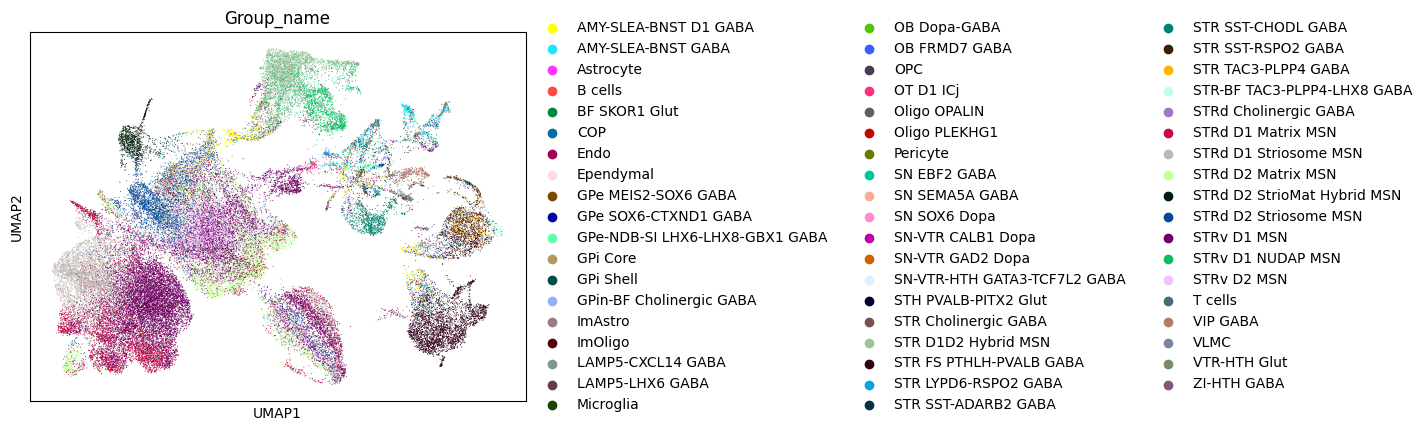

In [22]:
sc.pl.umap(a, color=["Group_name"])

# Plot

ATTENTION: the zones even if called 1-6 for all cell types they have differnt spatial pattern for each cell type.

In [13]:
# Zone colors palette
size=20

palette_str = os.getenv("PALETTE")
palette = {int(k): v for k, v in json.loads(palette_str).items()}
palette

{1: '#9467bd',
 2: '#8c564b',
 3: '#2ca02c',
 4: '#d62728',
 5: '#1f77b4',
 6: '#ff7f0e'}

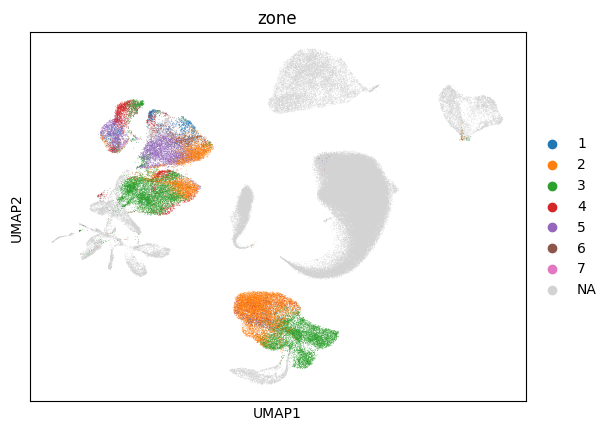

In [14]:
sc.pl.umap(query, color="zone")



=== Mapping cell type: STR D1 Matrix MSN using reference: STR_D1_Matrix_MSN ===

Subsetting to STR D1 Matrix MSN cells...


  Found 7772 cells


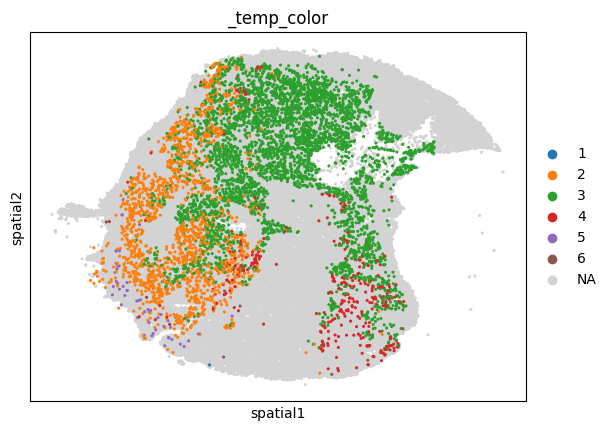

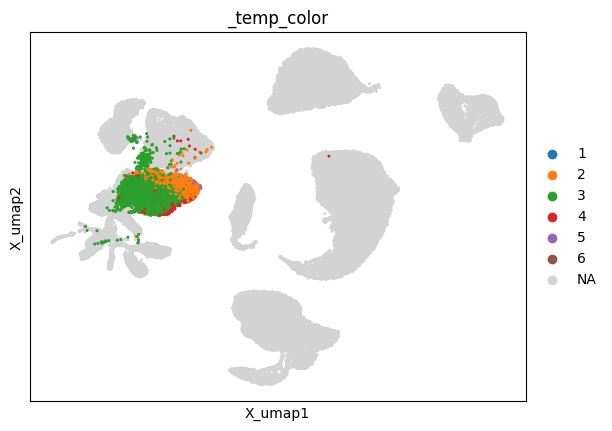

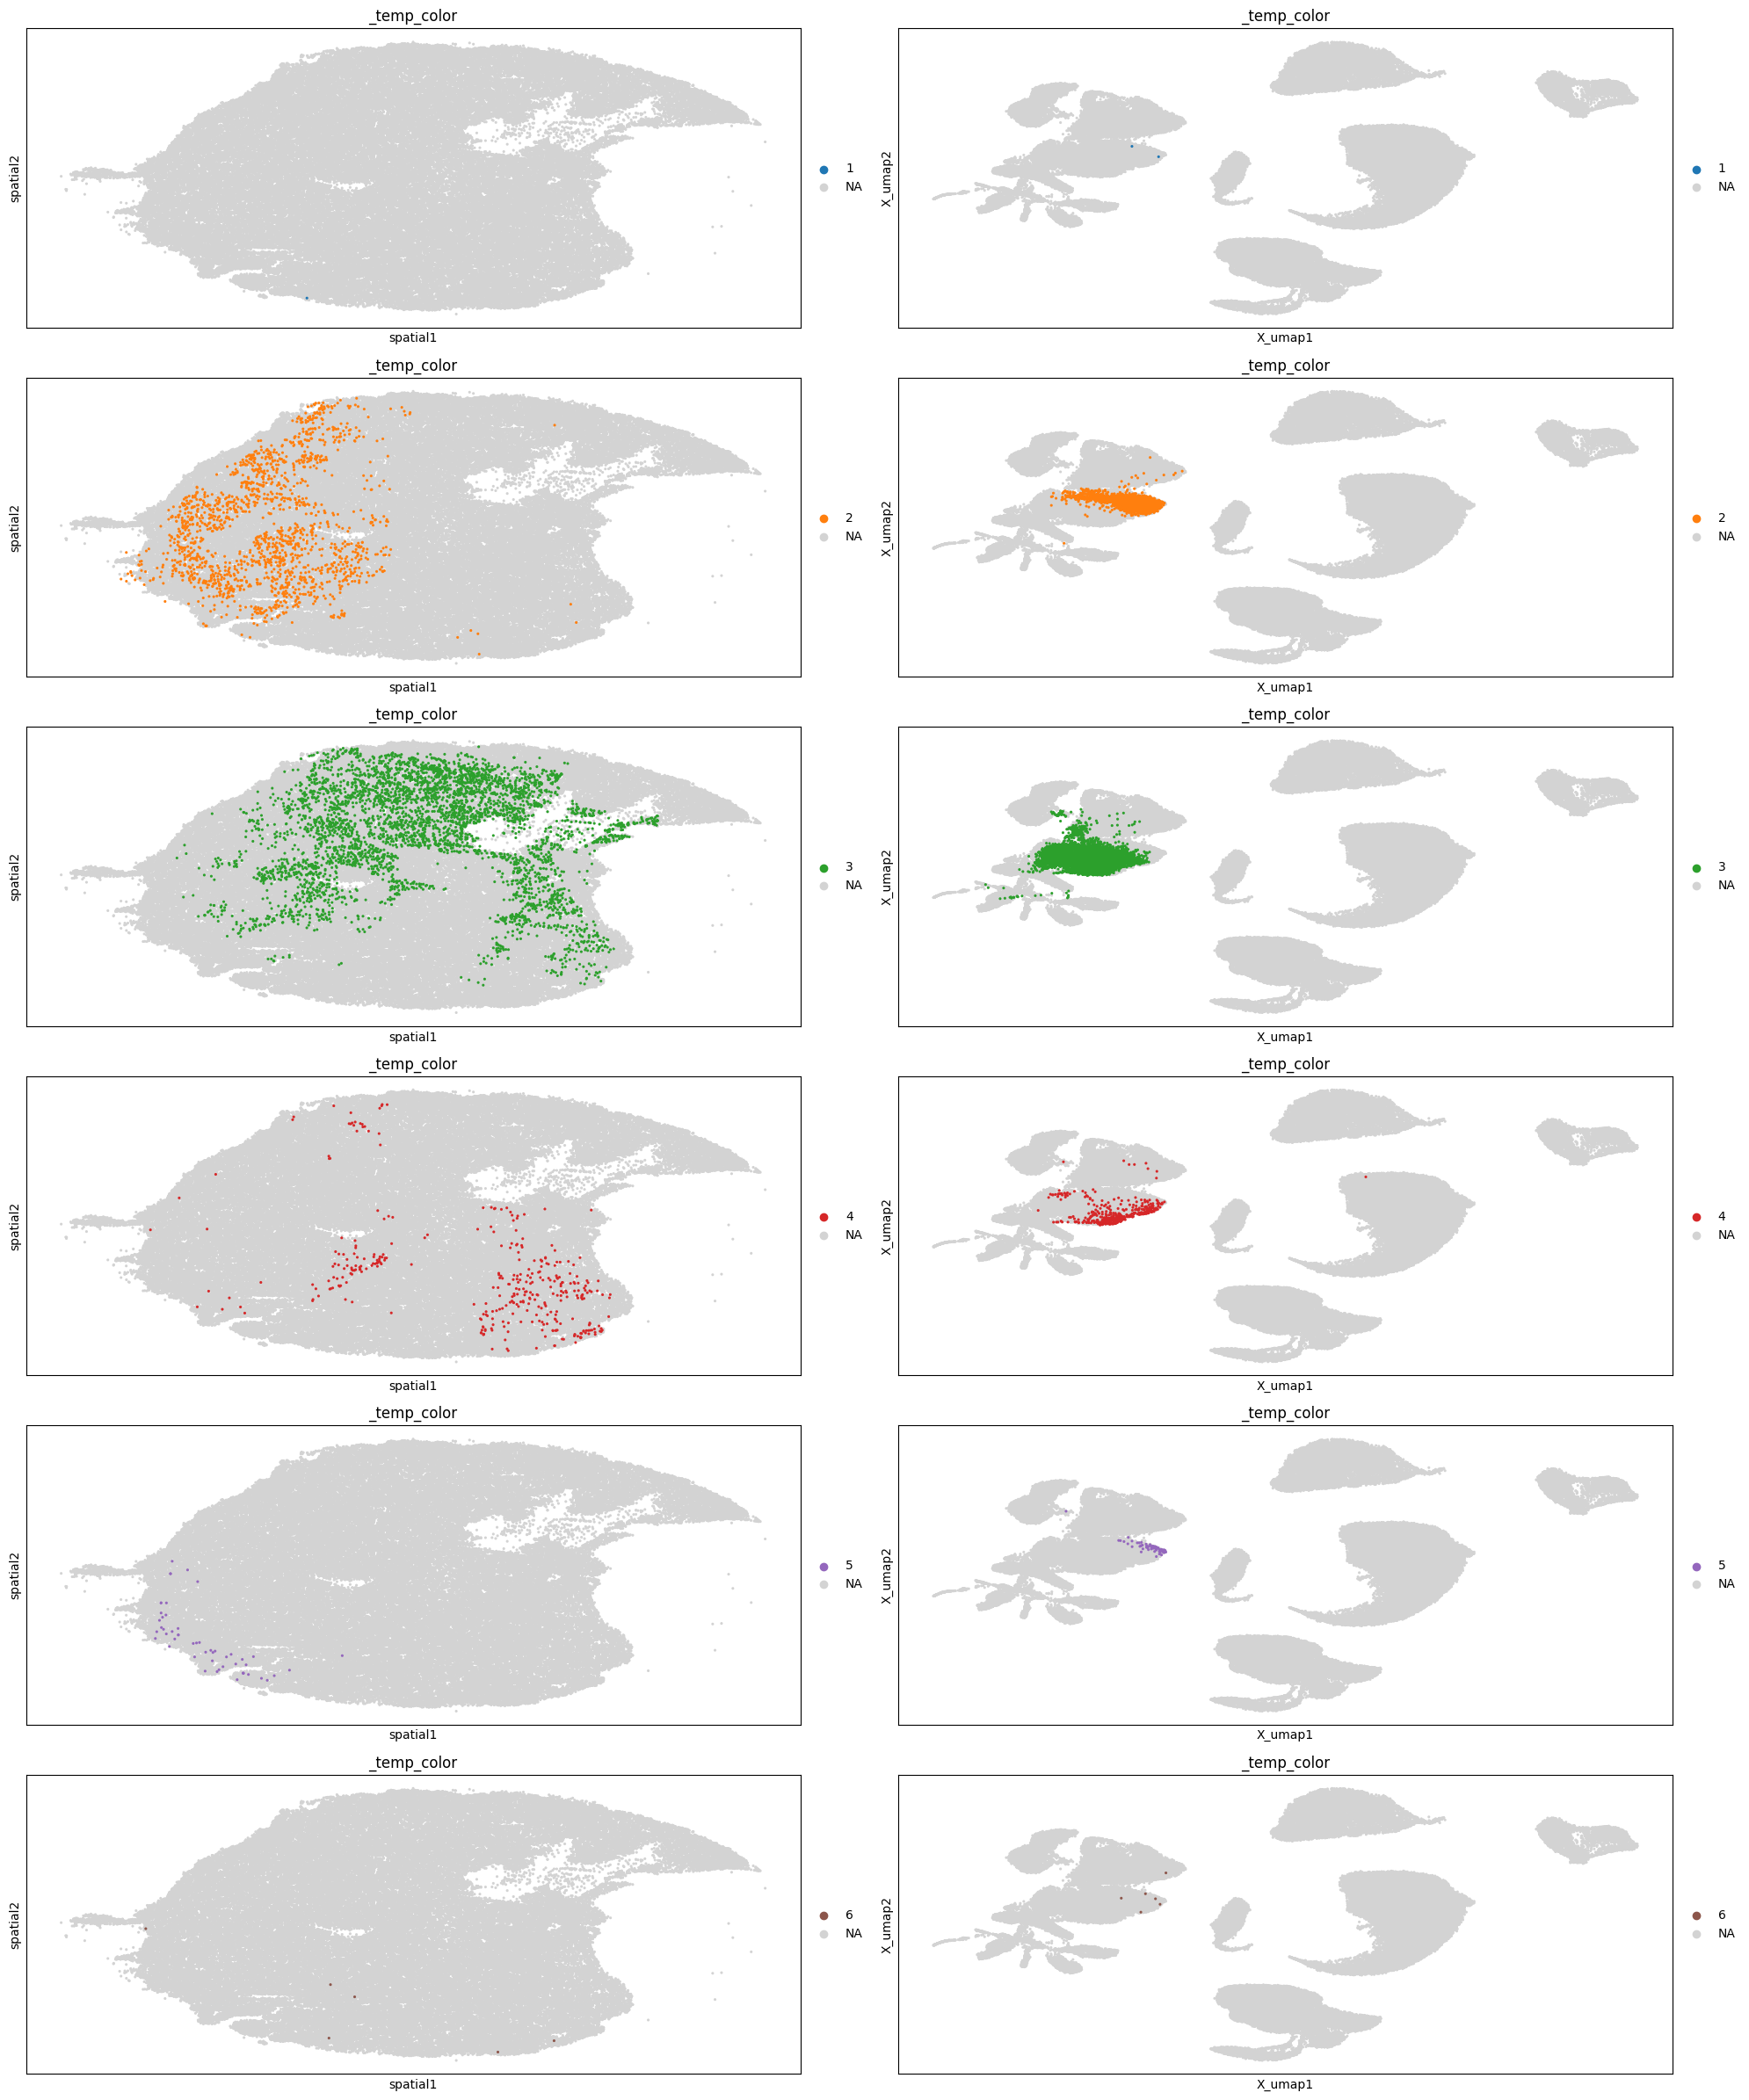



=== Mapping cell type: STR D2 Matrix MSN using reference: STR_D2_Matrix_MSN ===

Subsetting to STR D2 Matrix MSN cells...
  Found 5912 cells


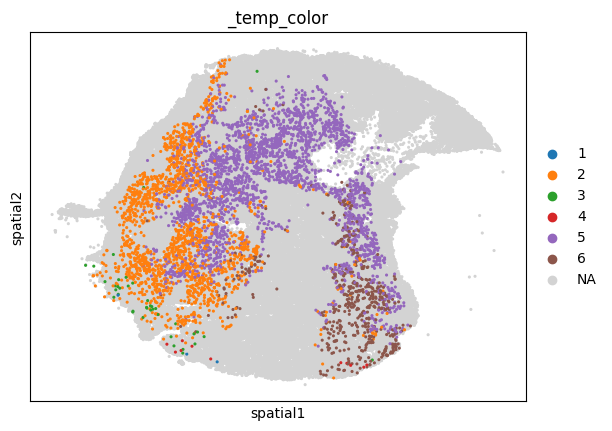

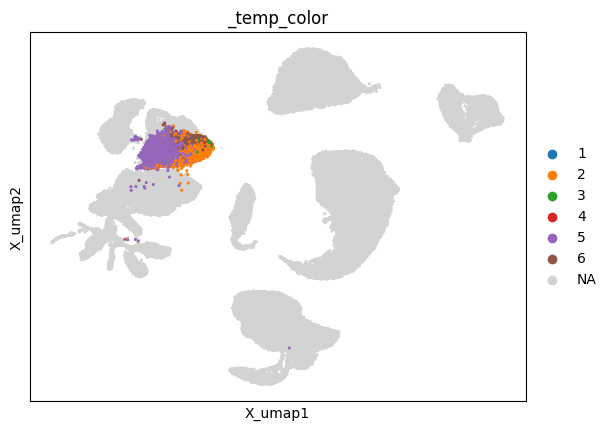

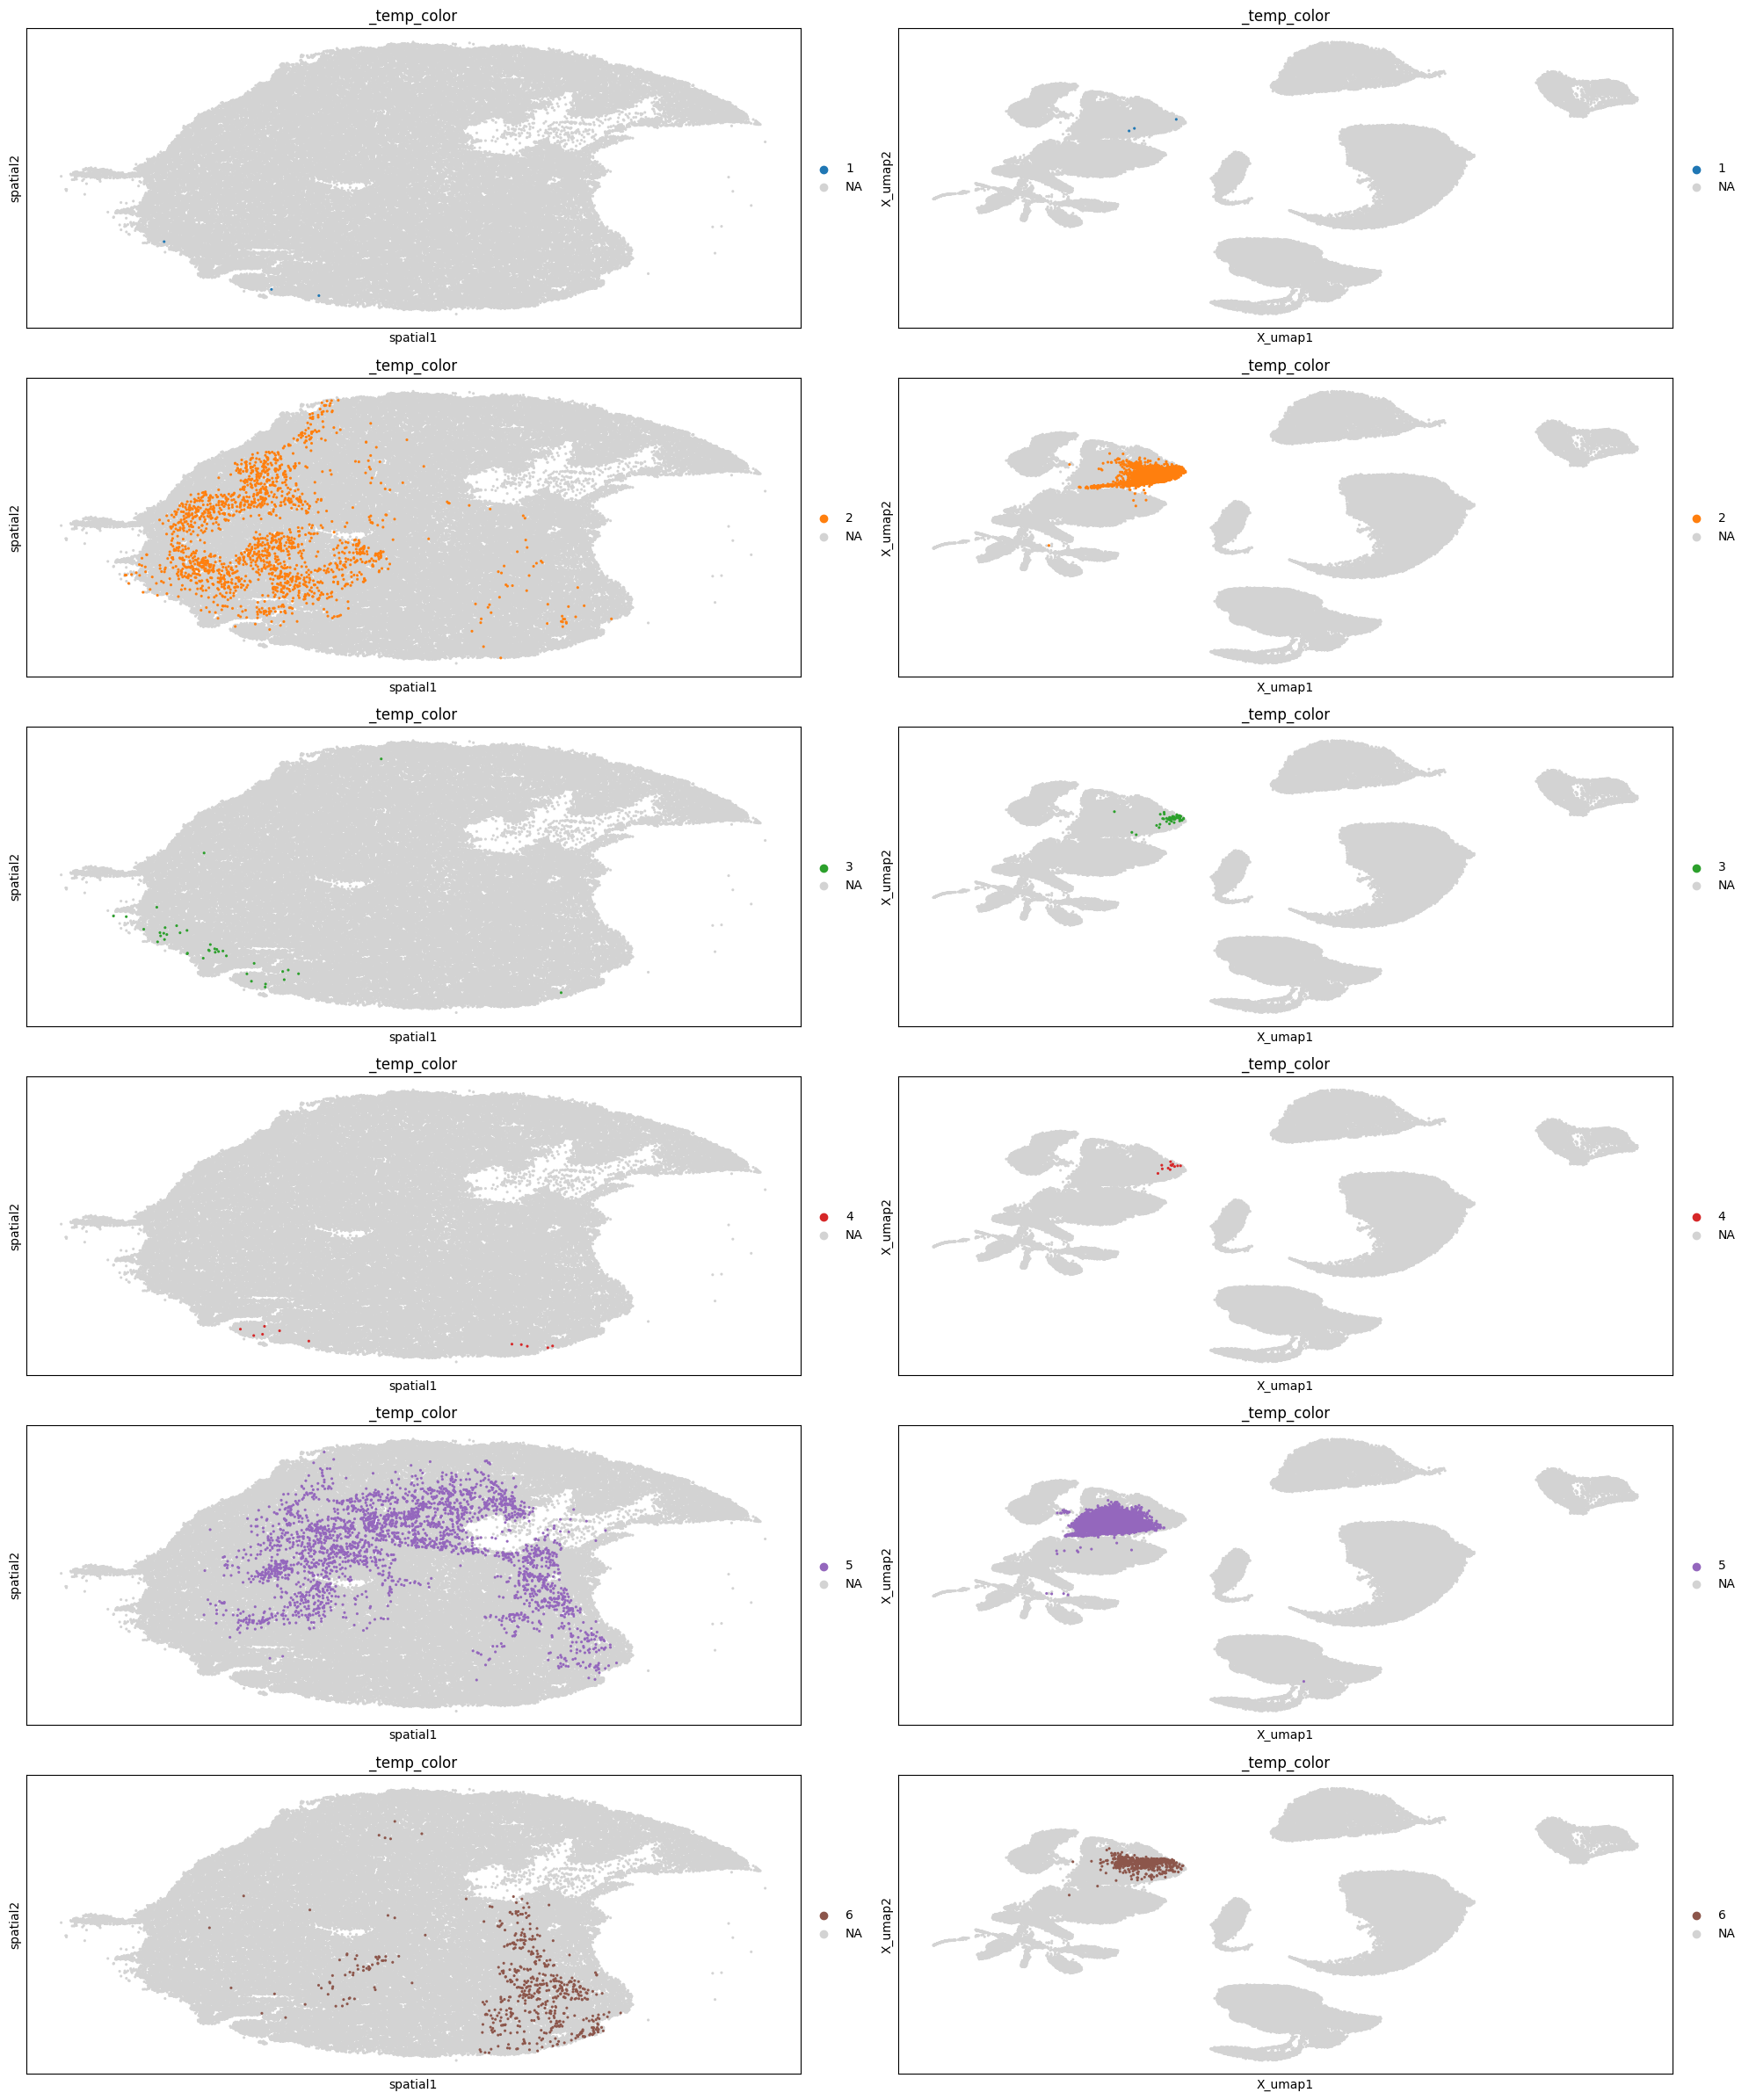



=== Mapping cell type: STRd D1 Striosome MSN using reference: STRd_D1_Striosome_MSN ===

Subsetting to STRd D1 Striosome MSN cells...
  Found 1085 cells


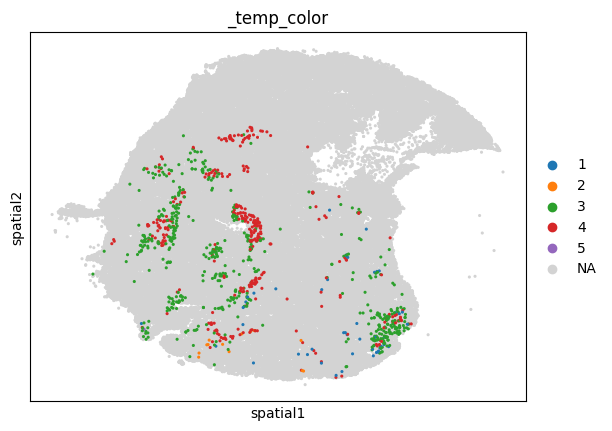

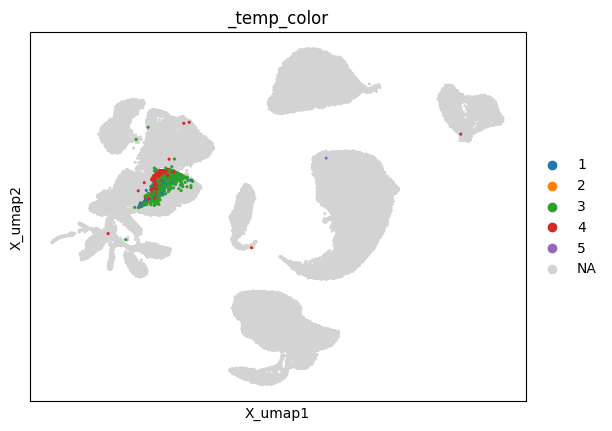

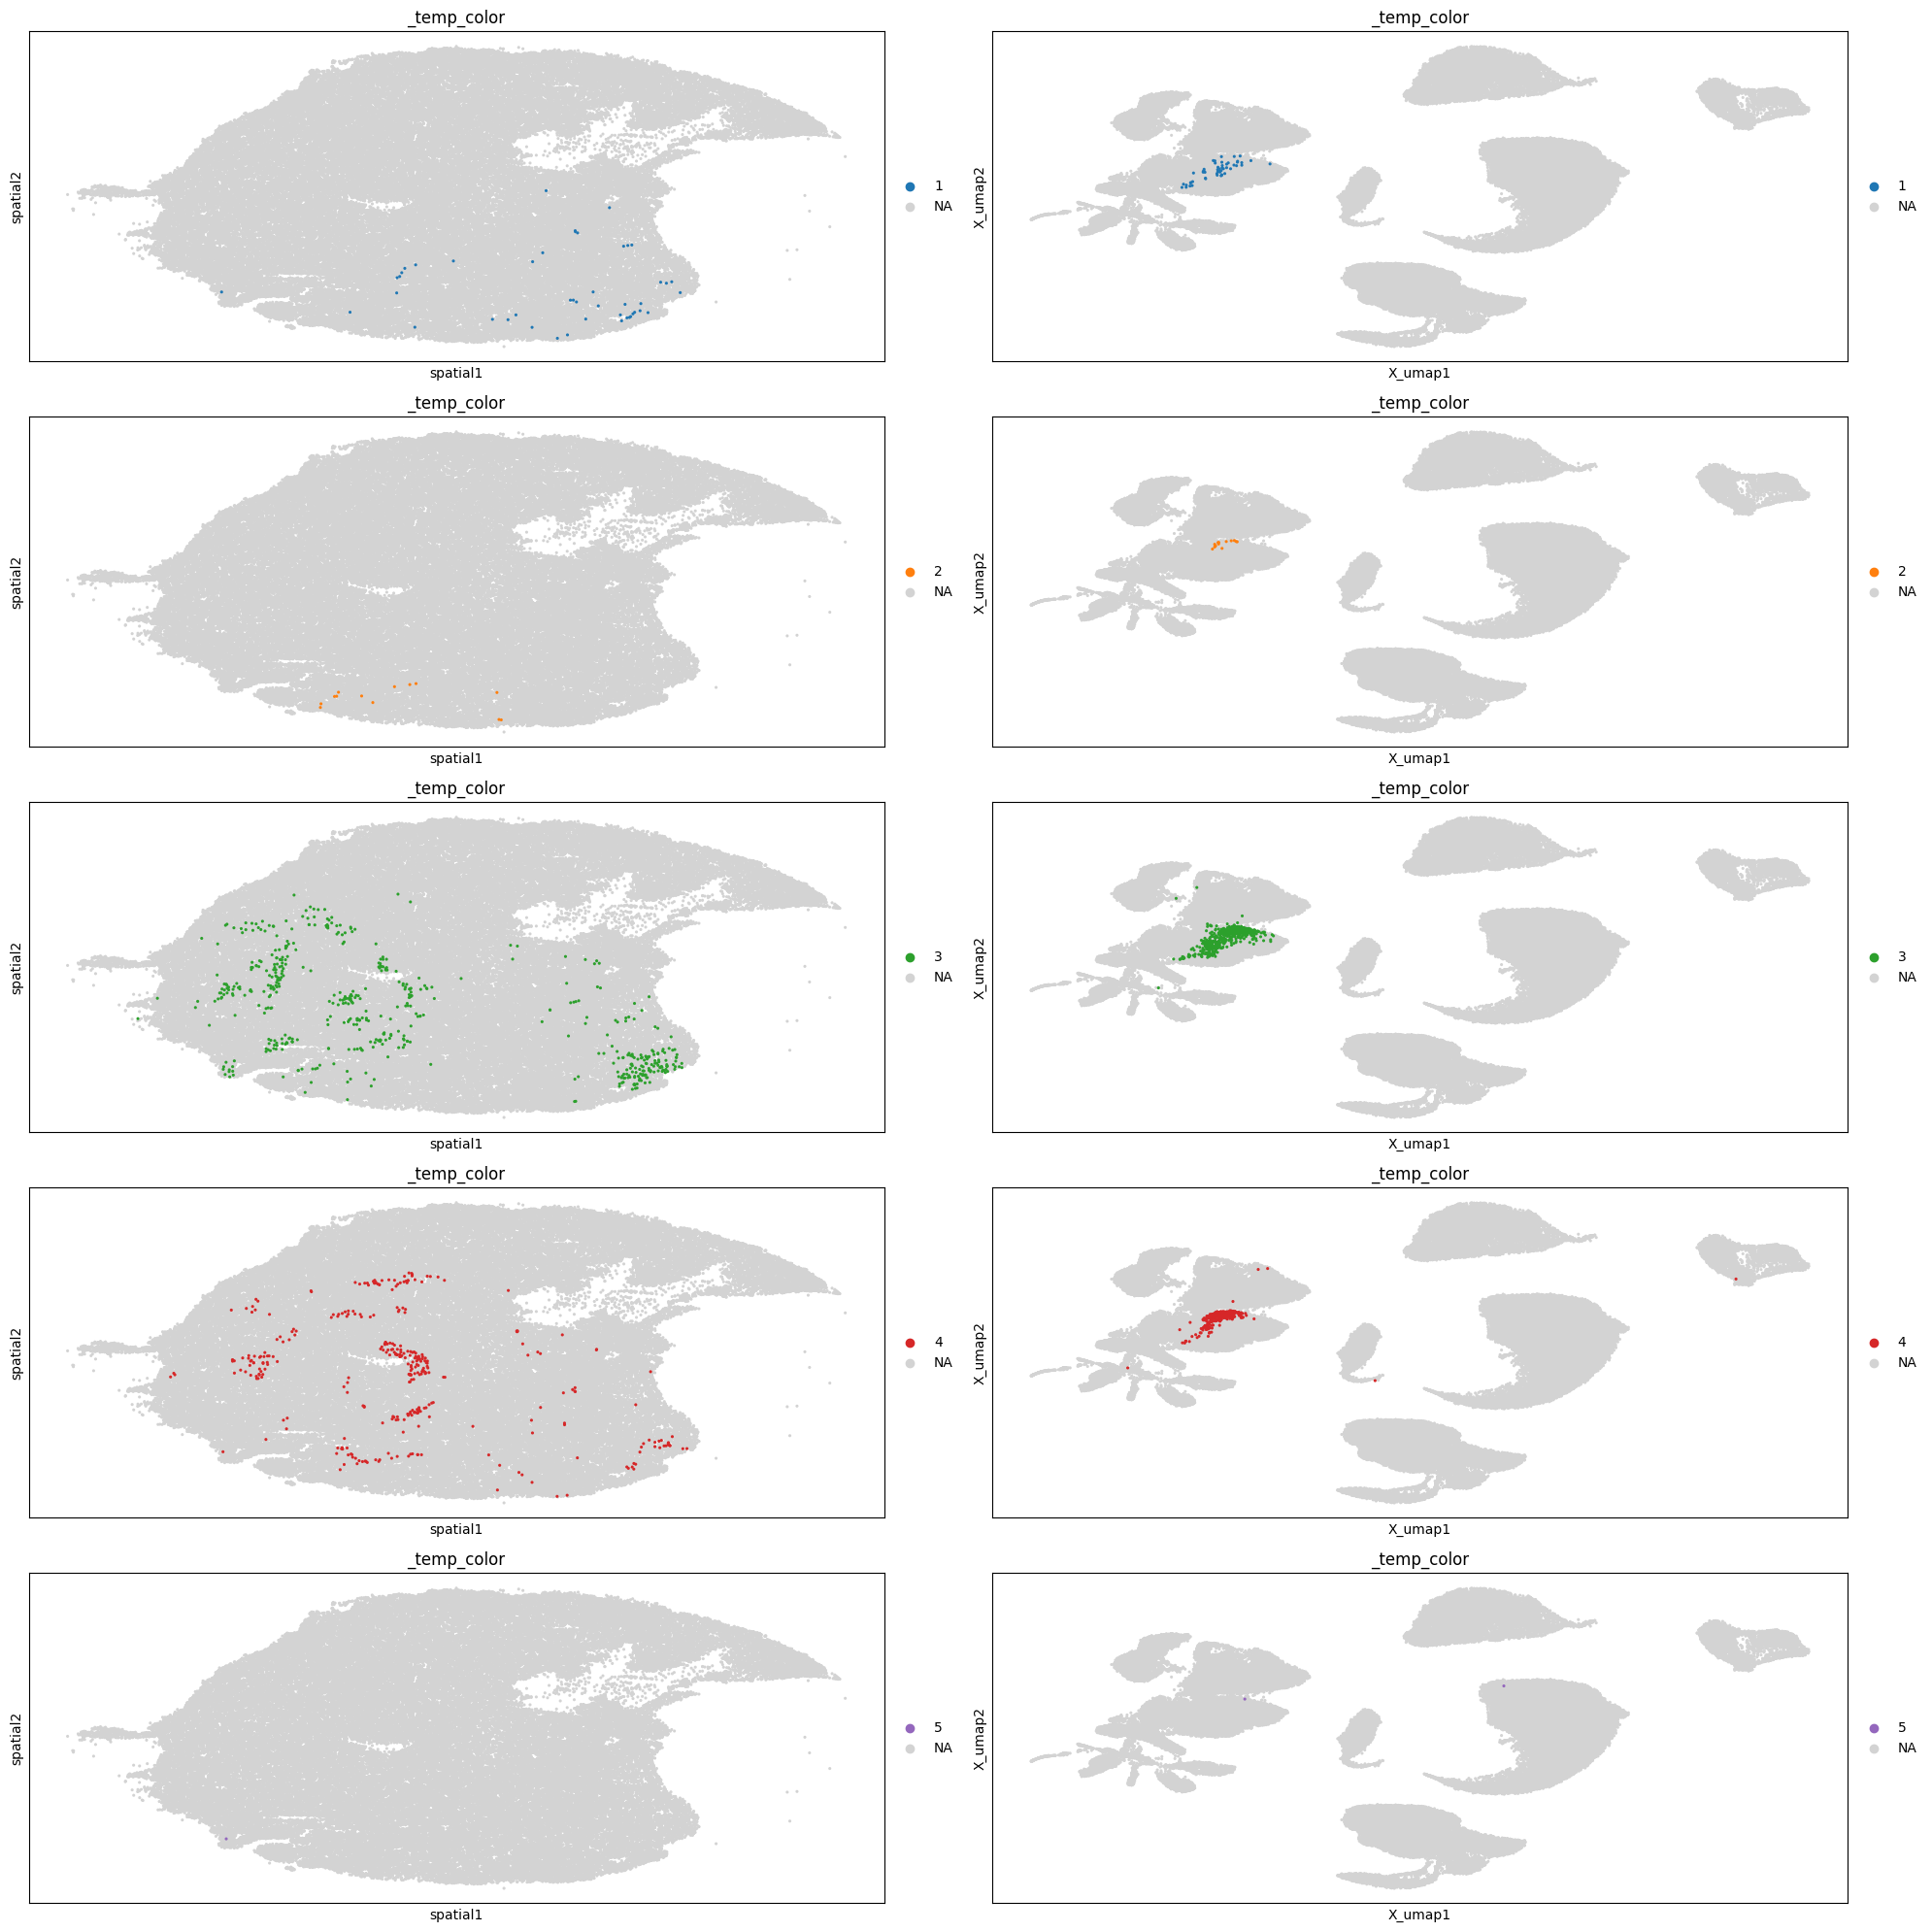



=== Mapping cell type: STRd D2 Striosome MSN using reference: STRd_D2_Striosome_MSN ===

Subsetting to STRd D2 Striosome MSN cells...
  Found 778 cells


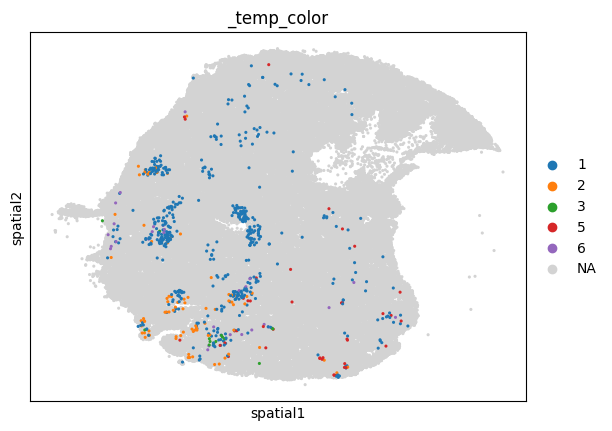

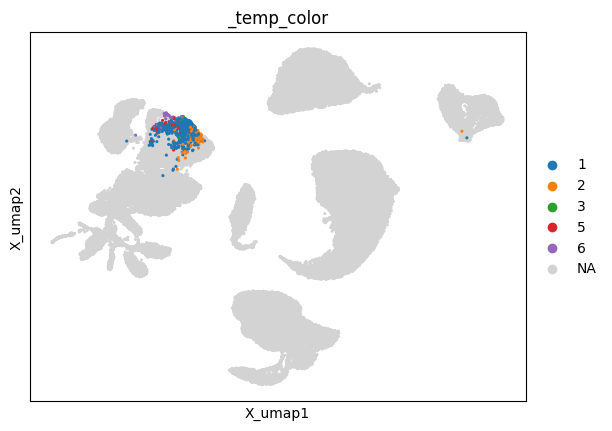

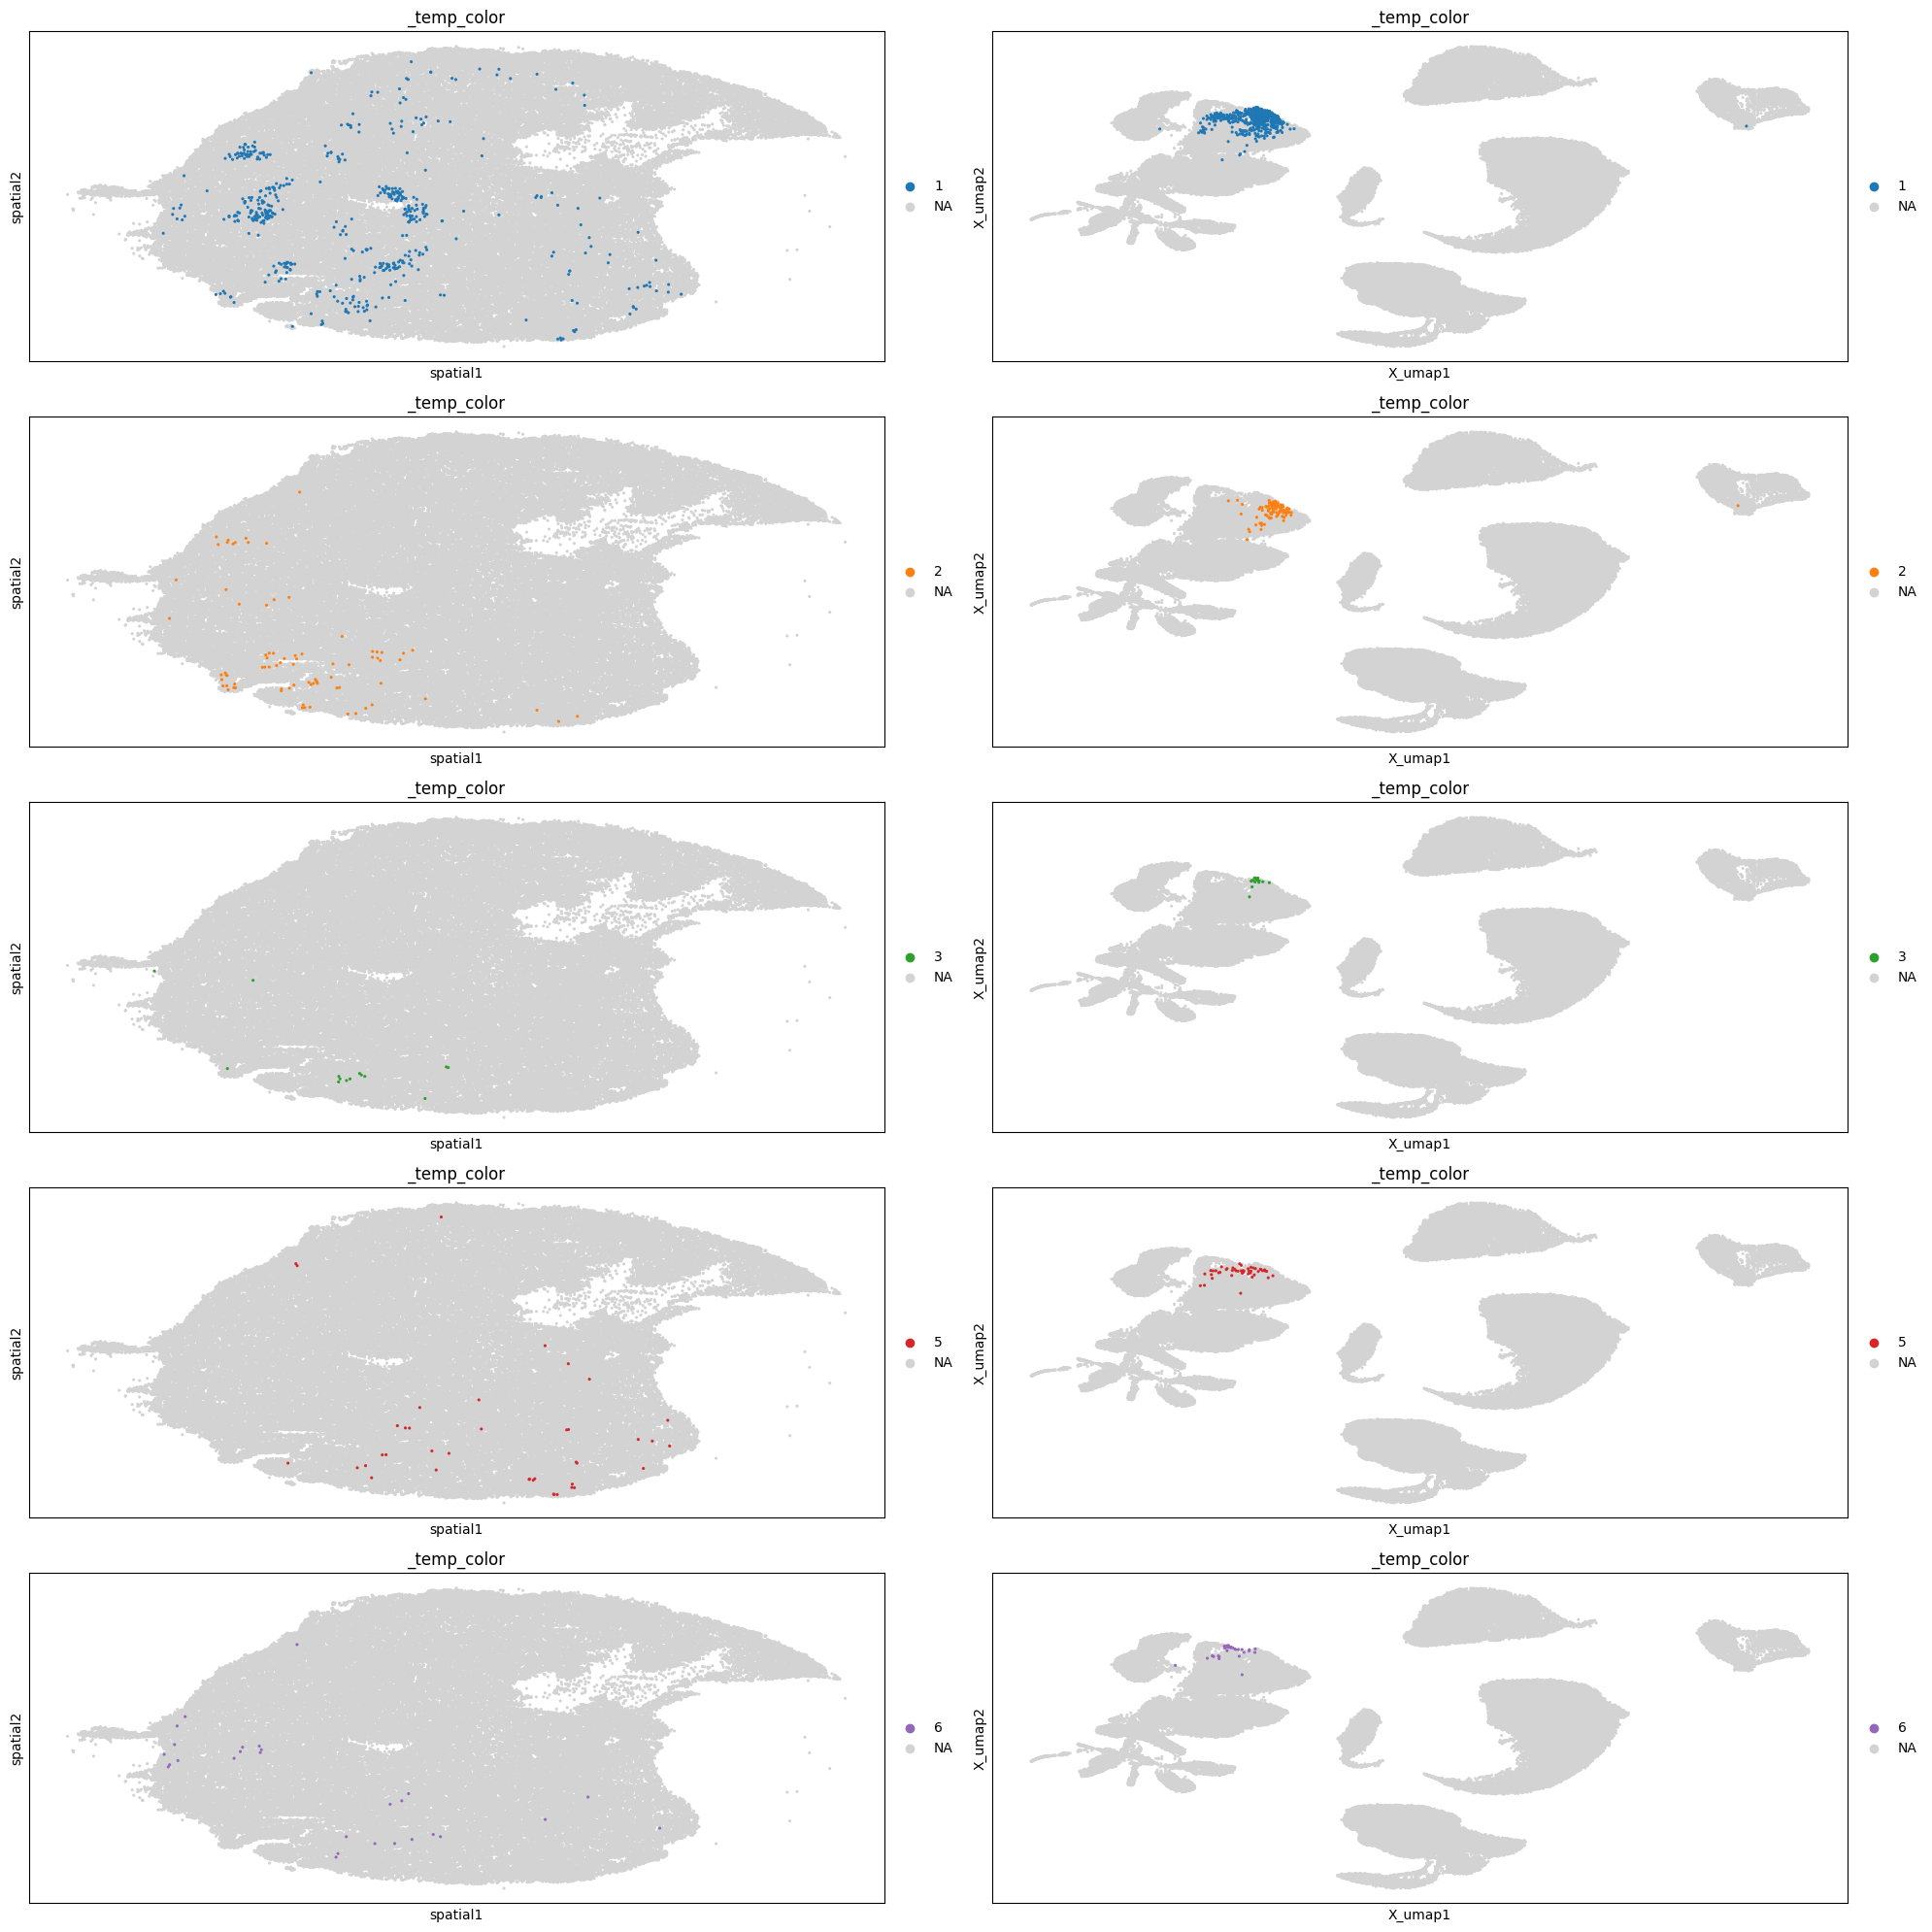



=== Mapping cell type: STRv D1 NUDAP MSN using reference: STRv_D1_NUDAP_MSN ===

Subsetting to STRv D1 NUDAP MSN cells...
  Found 2719 cells


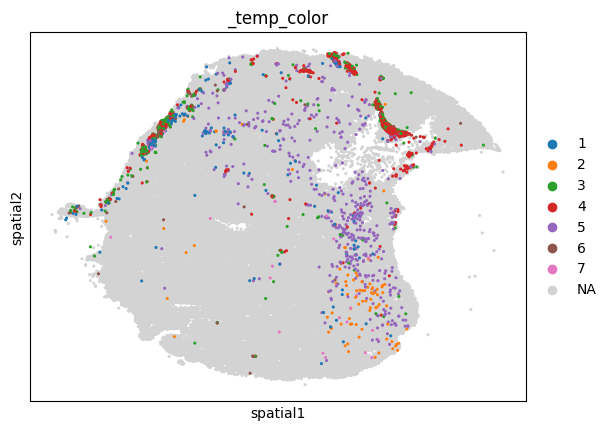

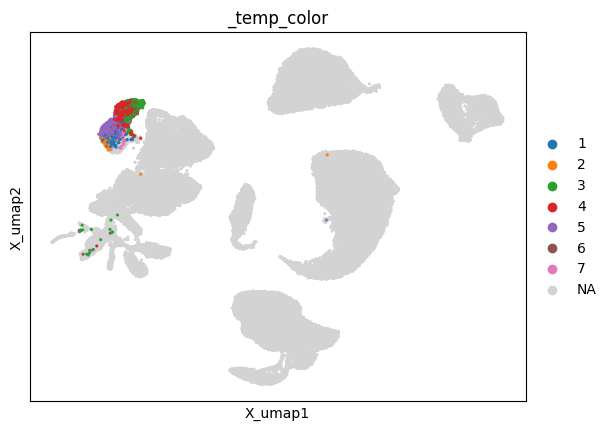

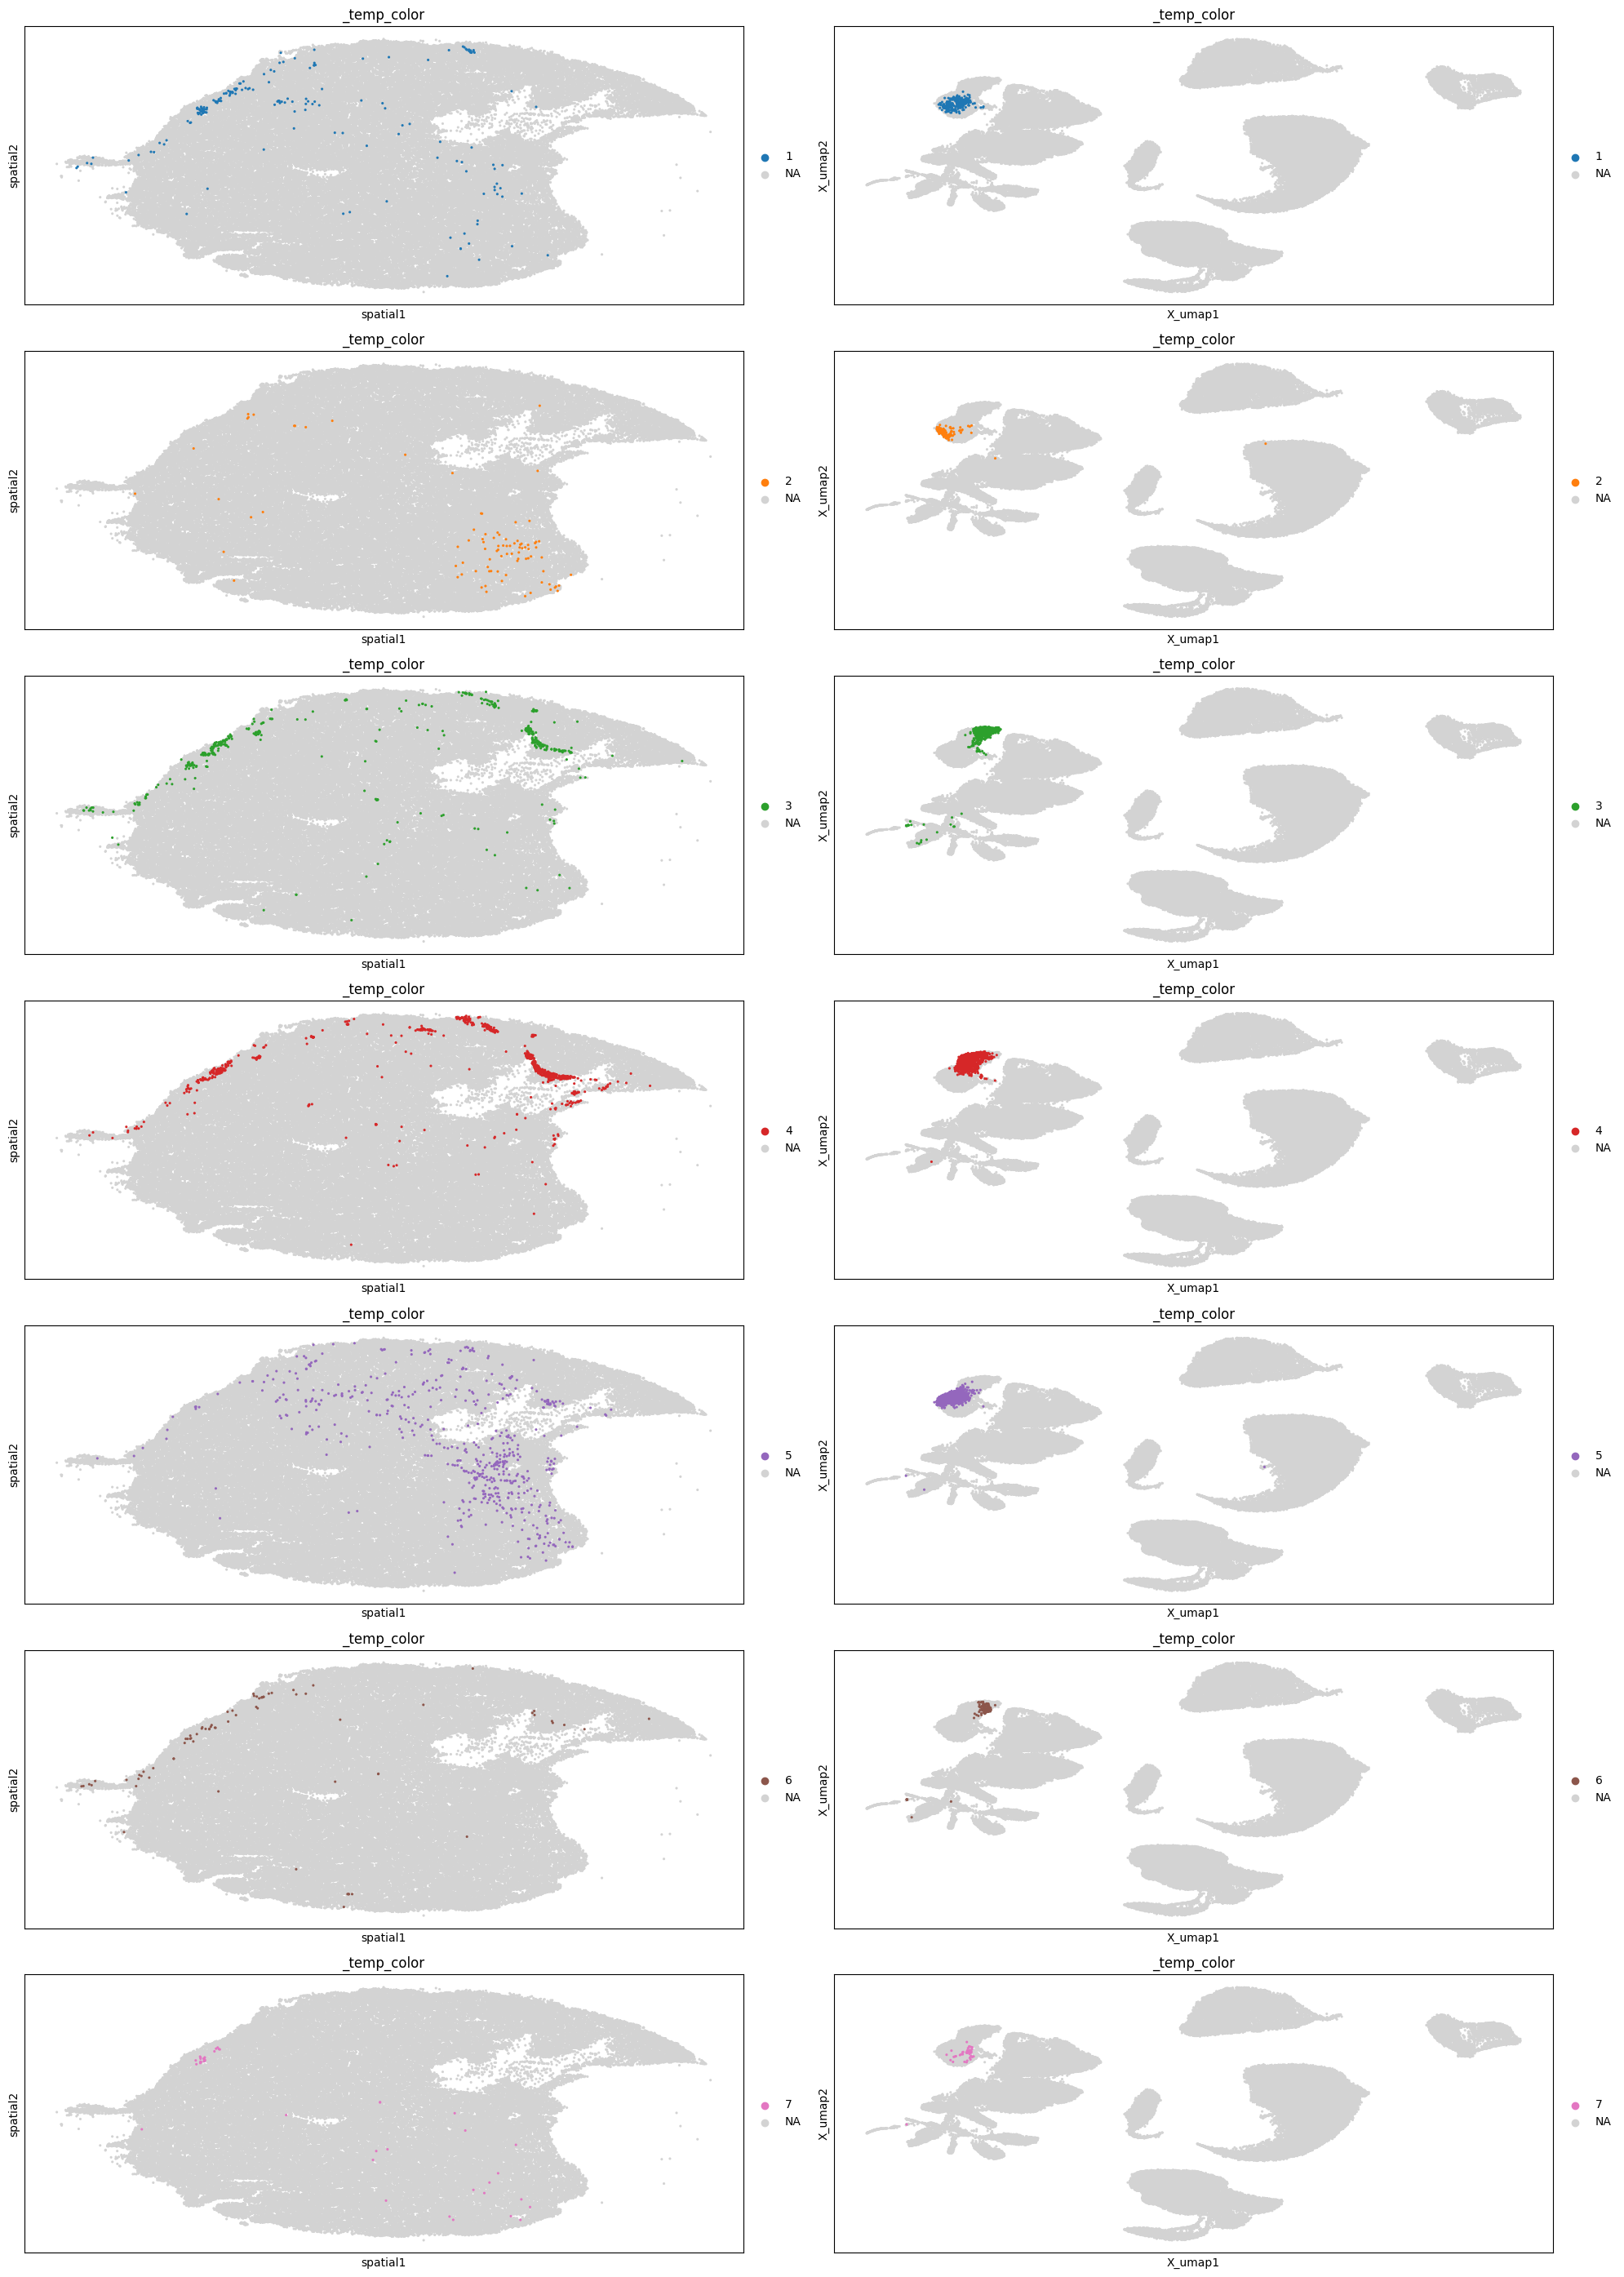



=== Mapping cell type: STR D1D2 Hybrid MSN using reference: STR_D1D2_Hybrid_MSN ===

Subsetting to STR D1D2 Hybrid MSN cells...
  Found 854 cells


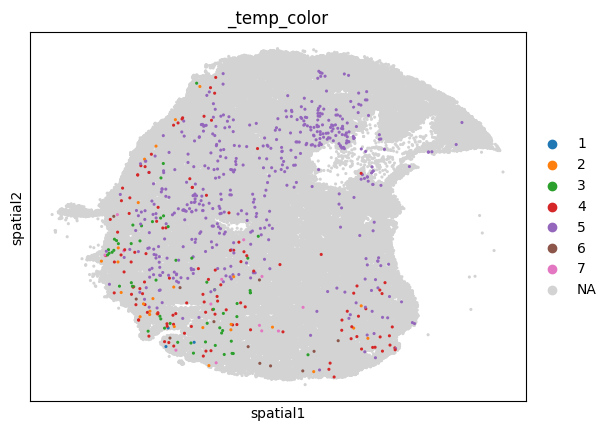

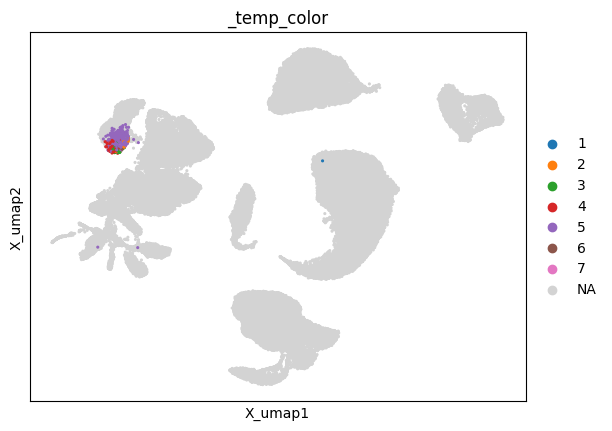

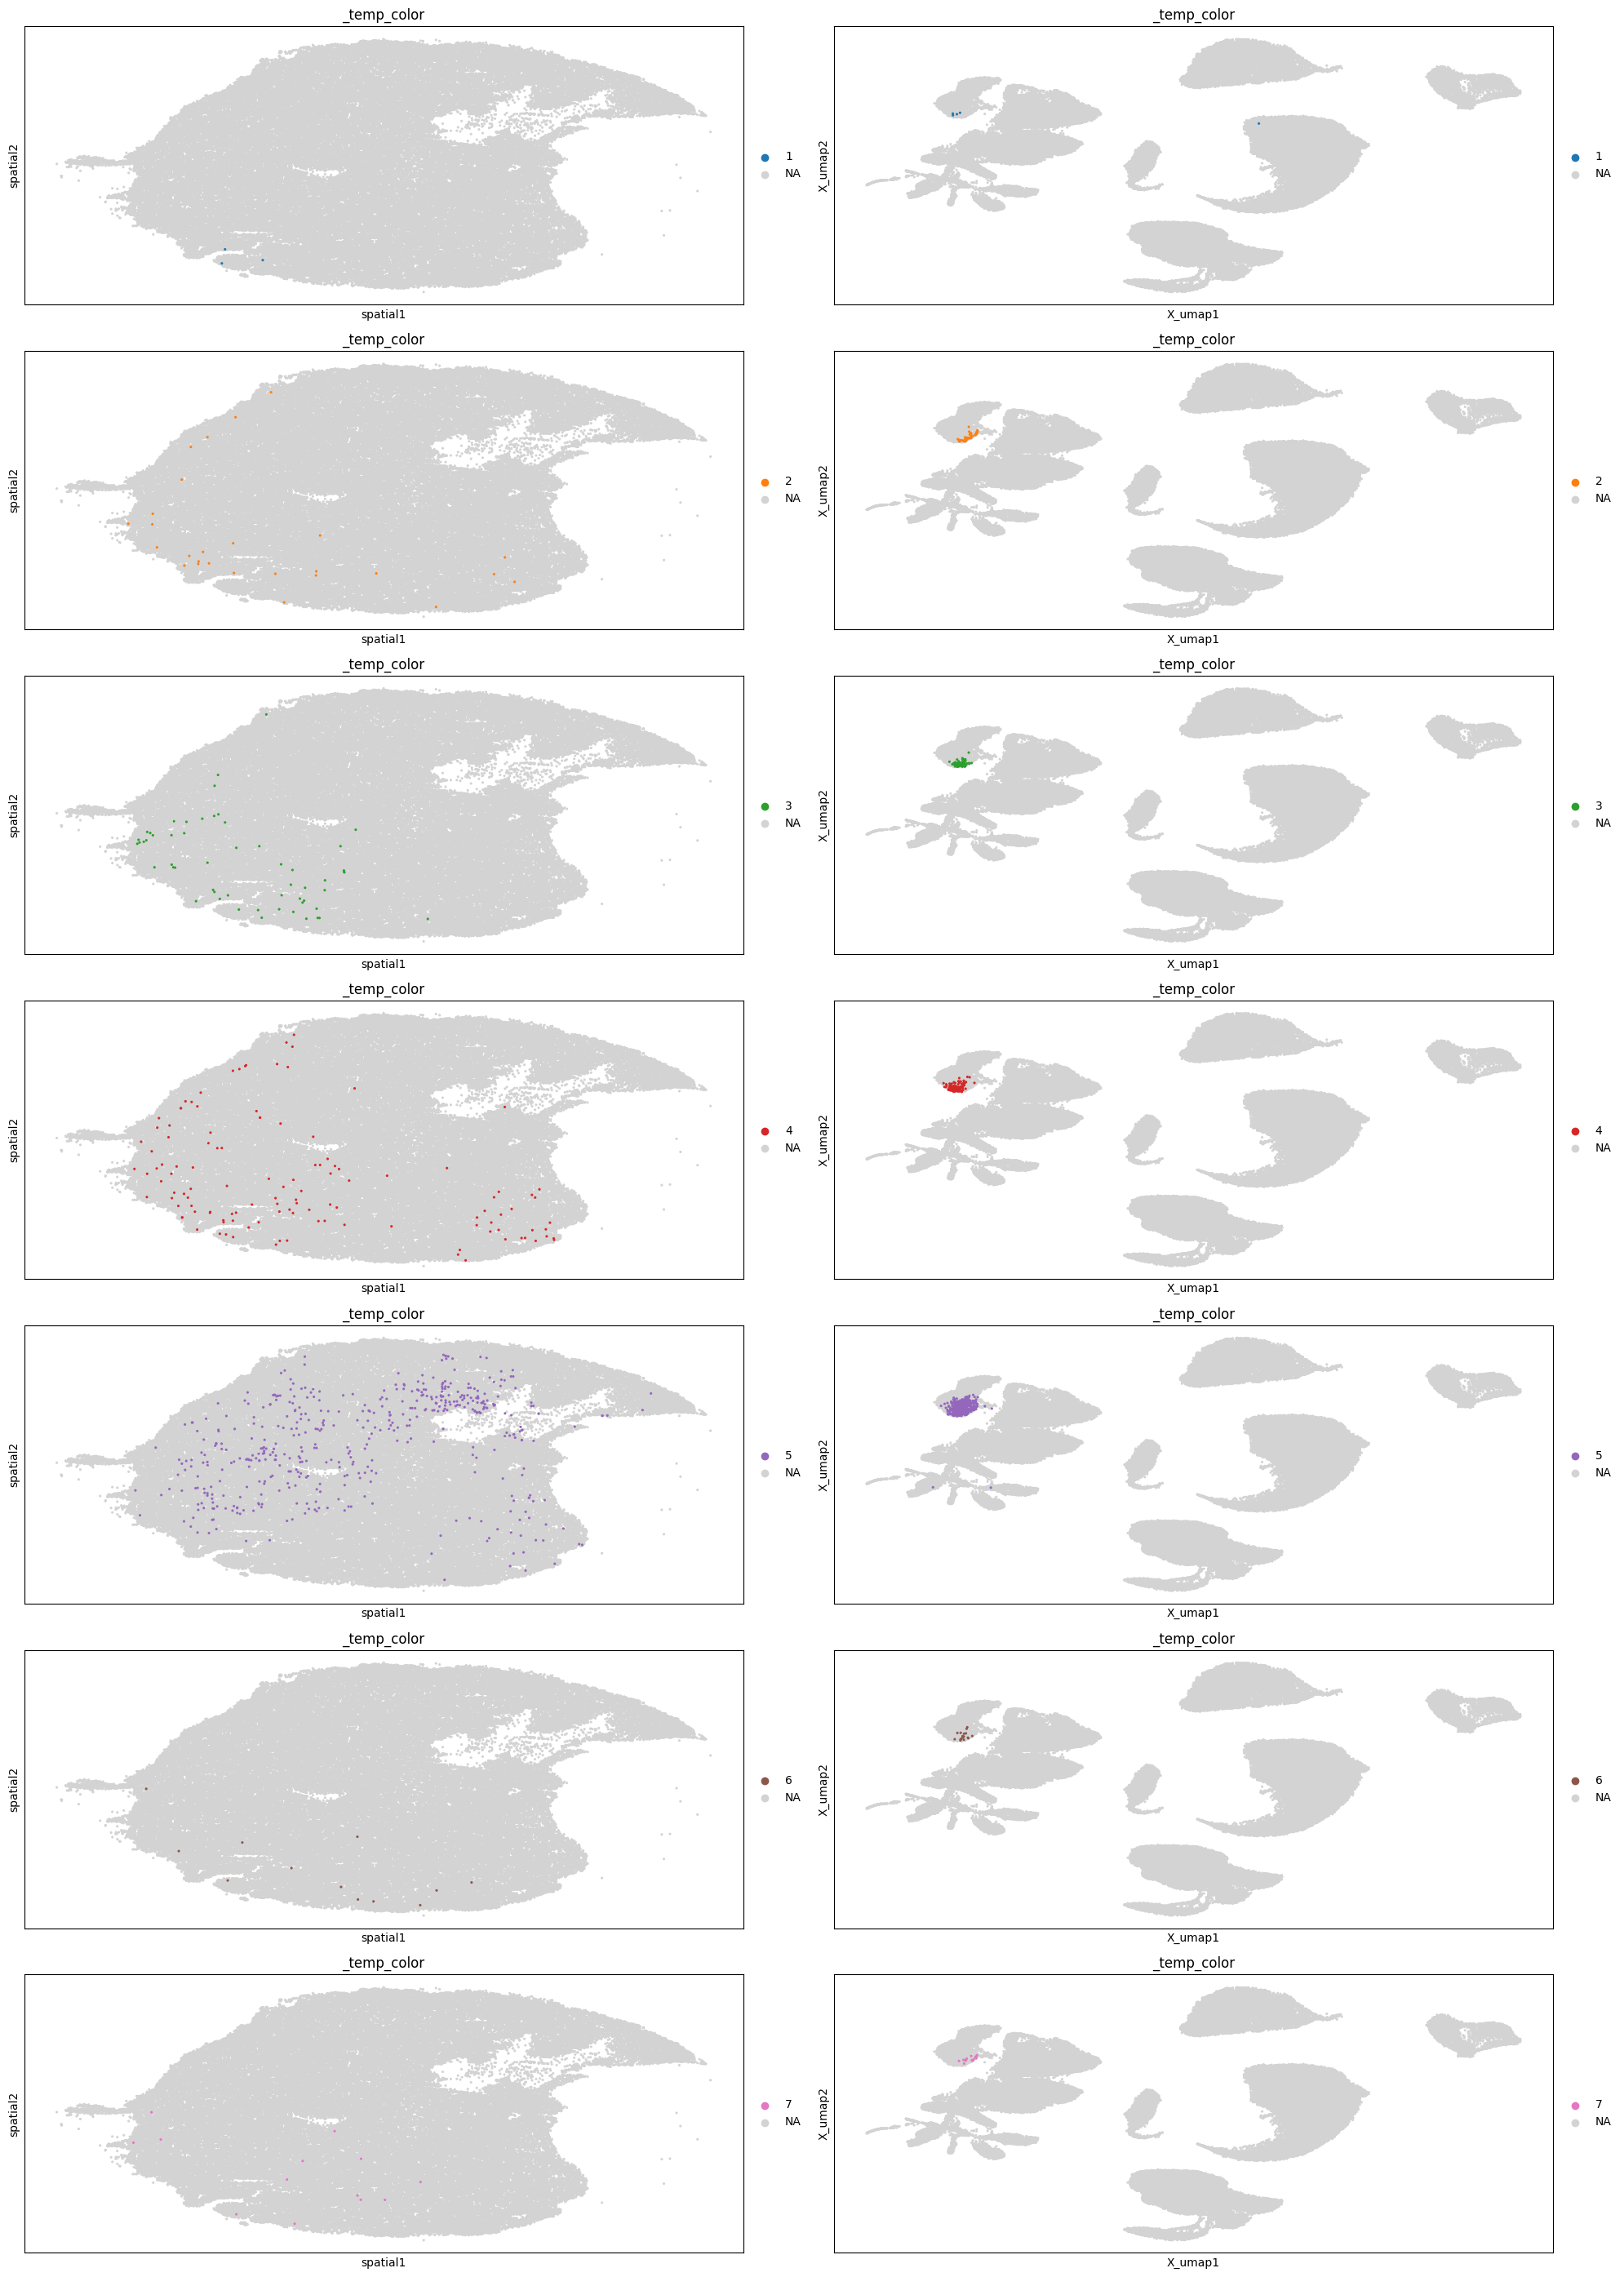



=== Mapping cell type: STRd D2 StrioMat Hybrid MSN using reference: STRd_D2_StrioMat_Hybrid_MSN ===

Subsetting to STRd D2 StrioMat Hybrid MSN cells...
  Found 594 cells


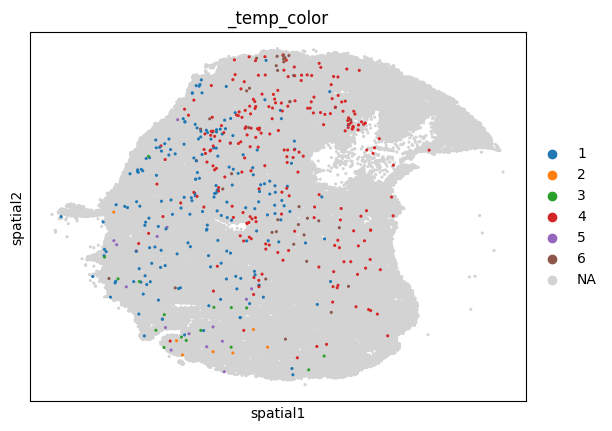

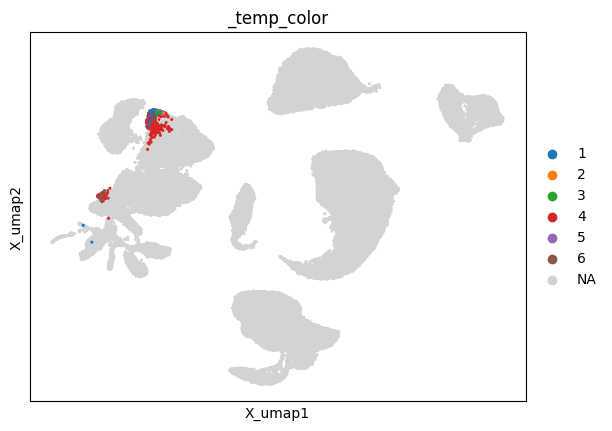

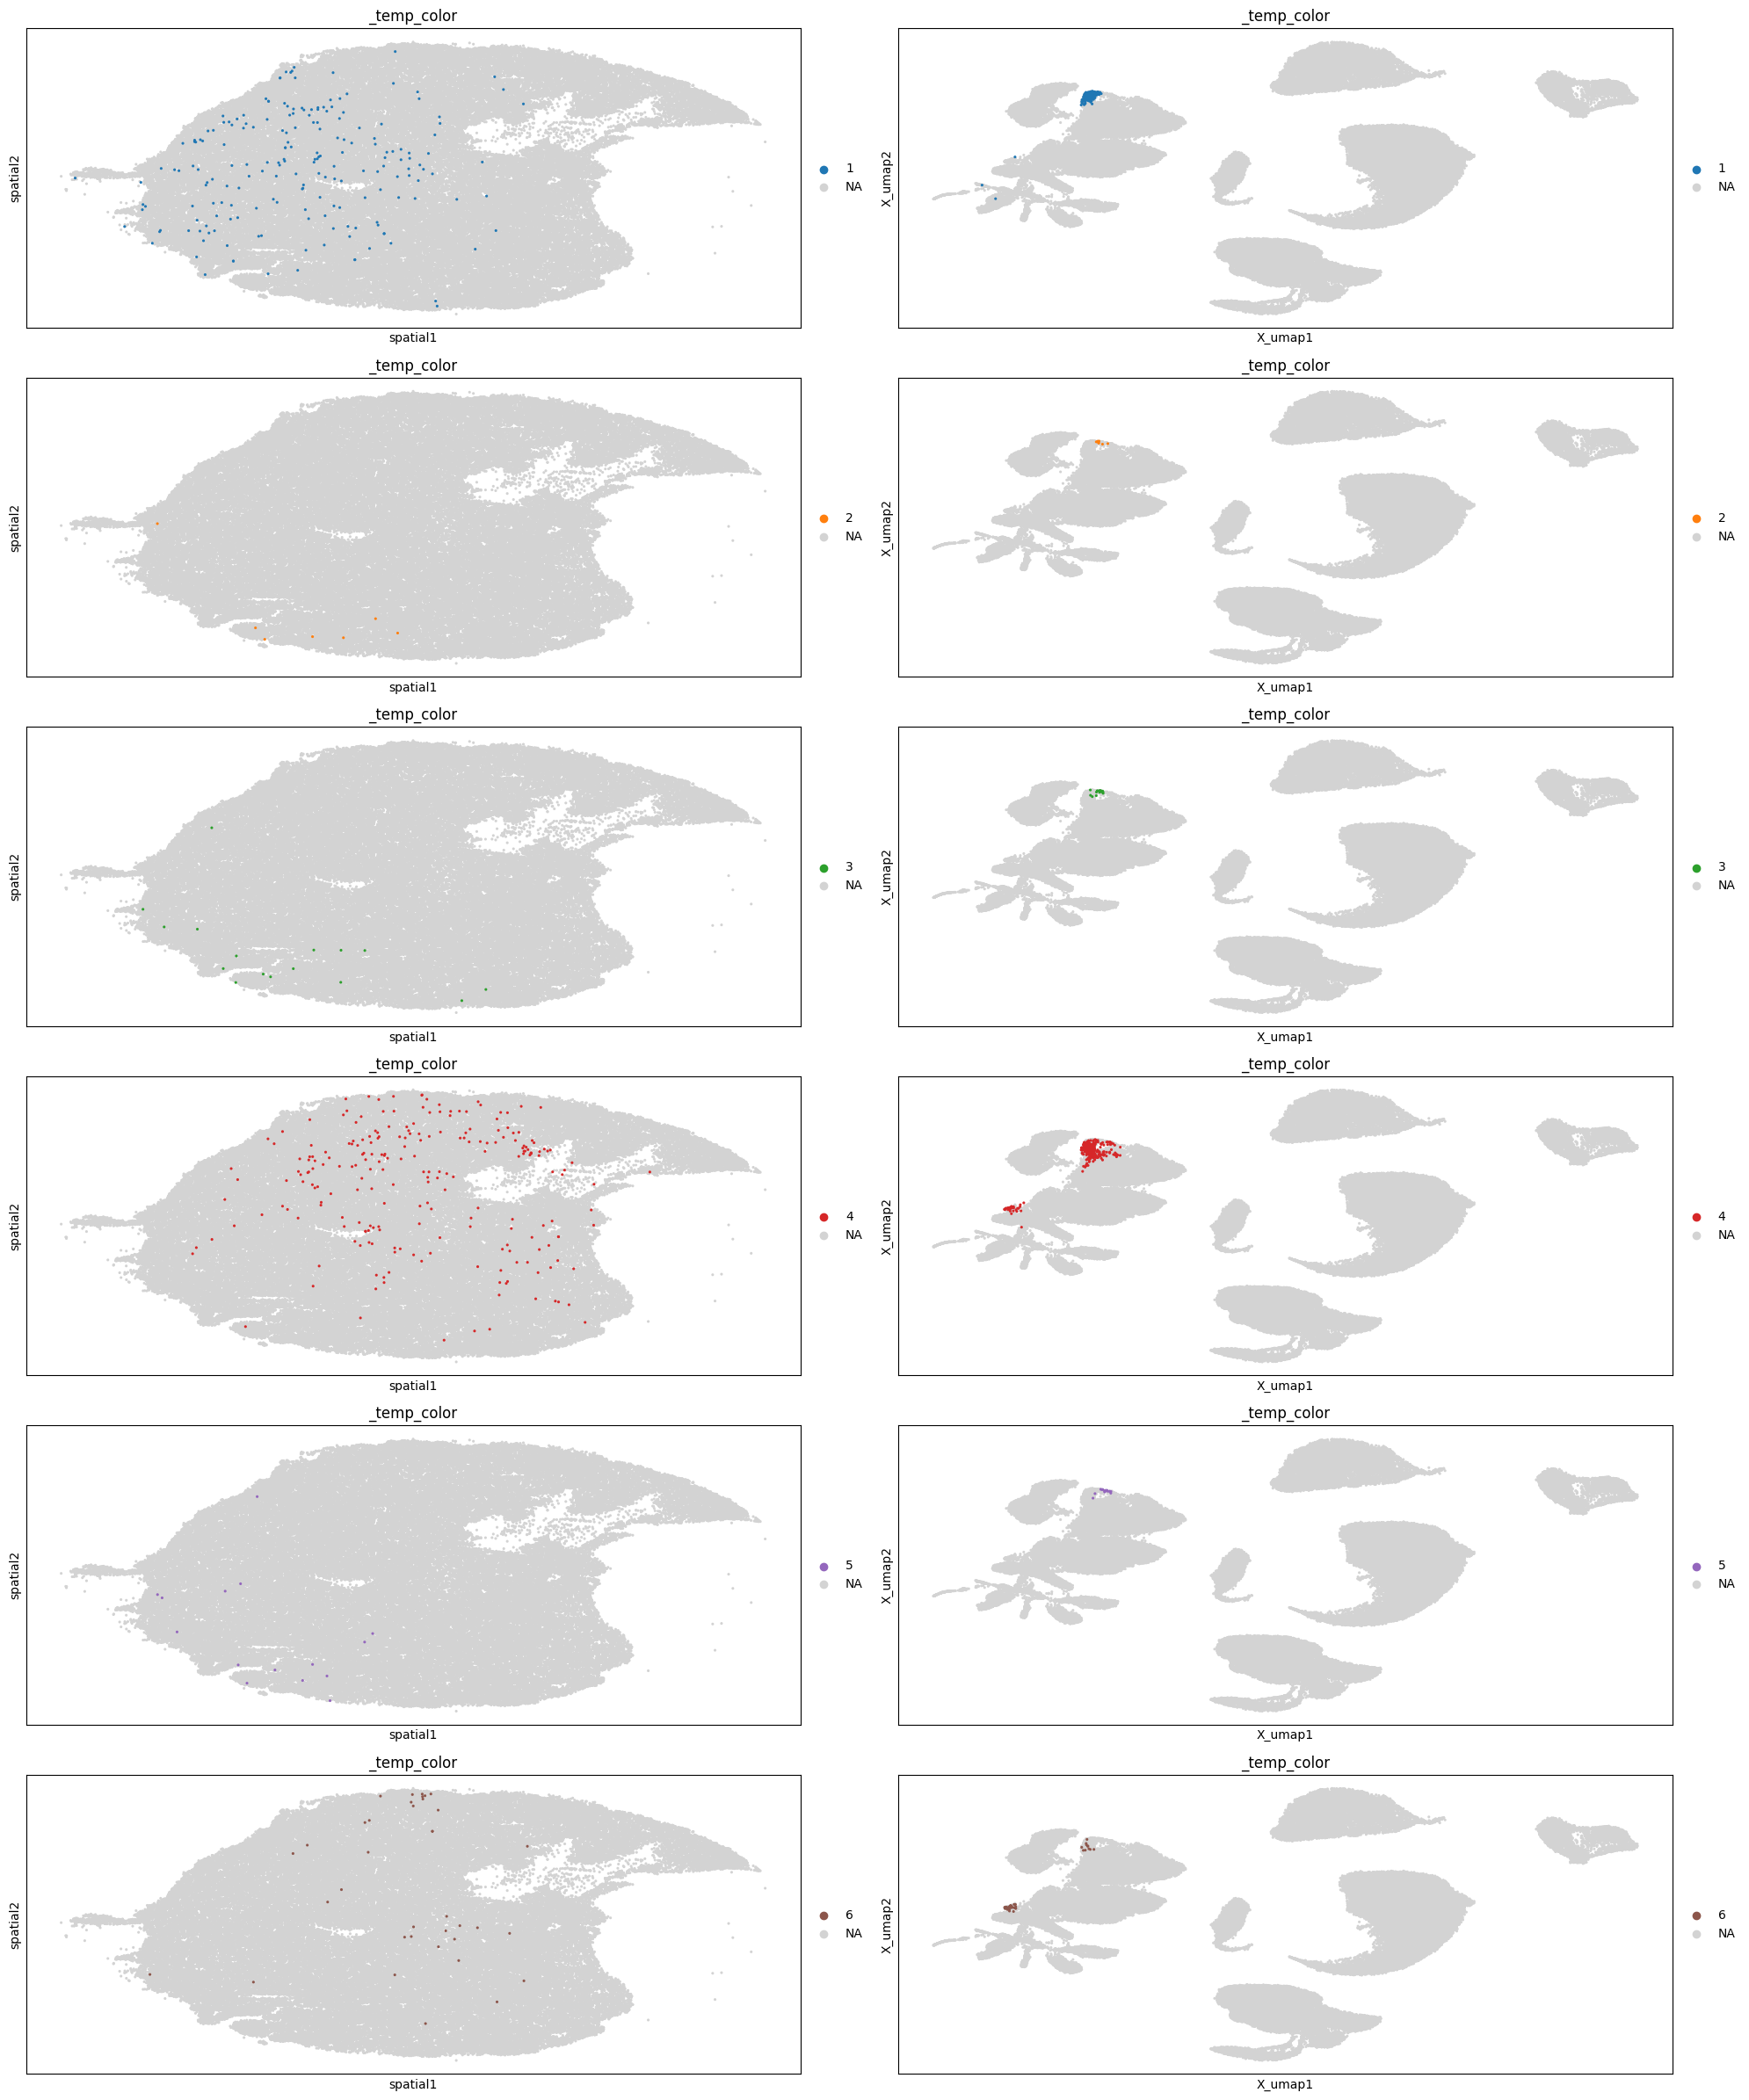



=== Mapping cell type: OPC using reference: OPC ===

Subsetting to OPC cells...
  Found 4810 cells
No zones found for OPC. Skipping visualization.


=== Mapping cell type: Astrocyte using reference: Astrocyte ===

Subsetting to Astrocyte cells...
  Found 14949 cells


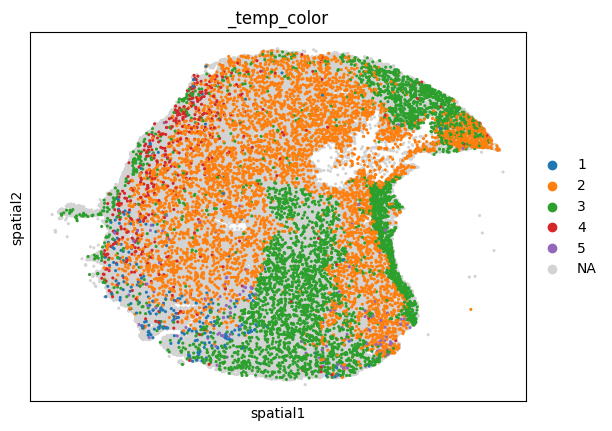

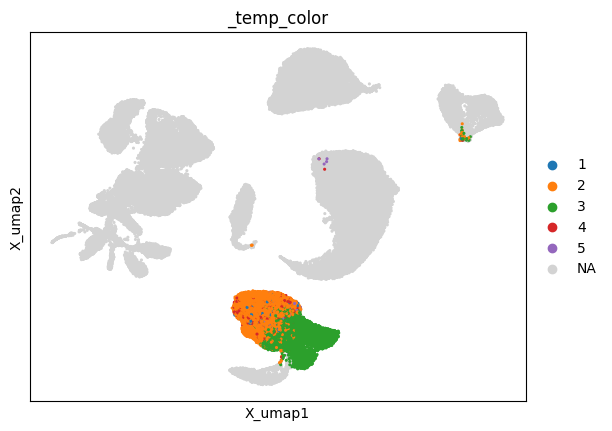

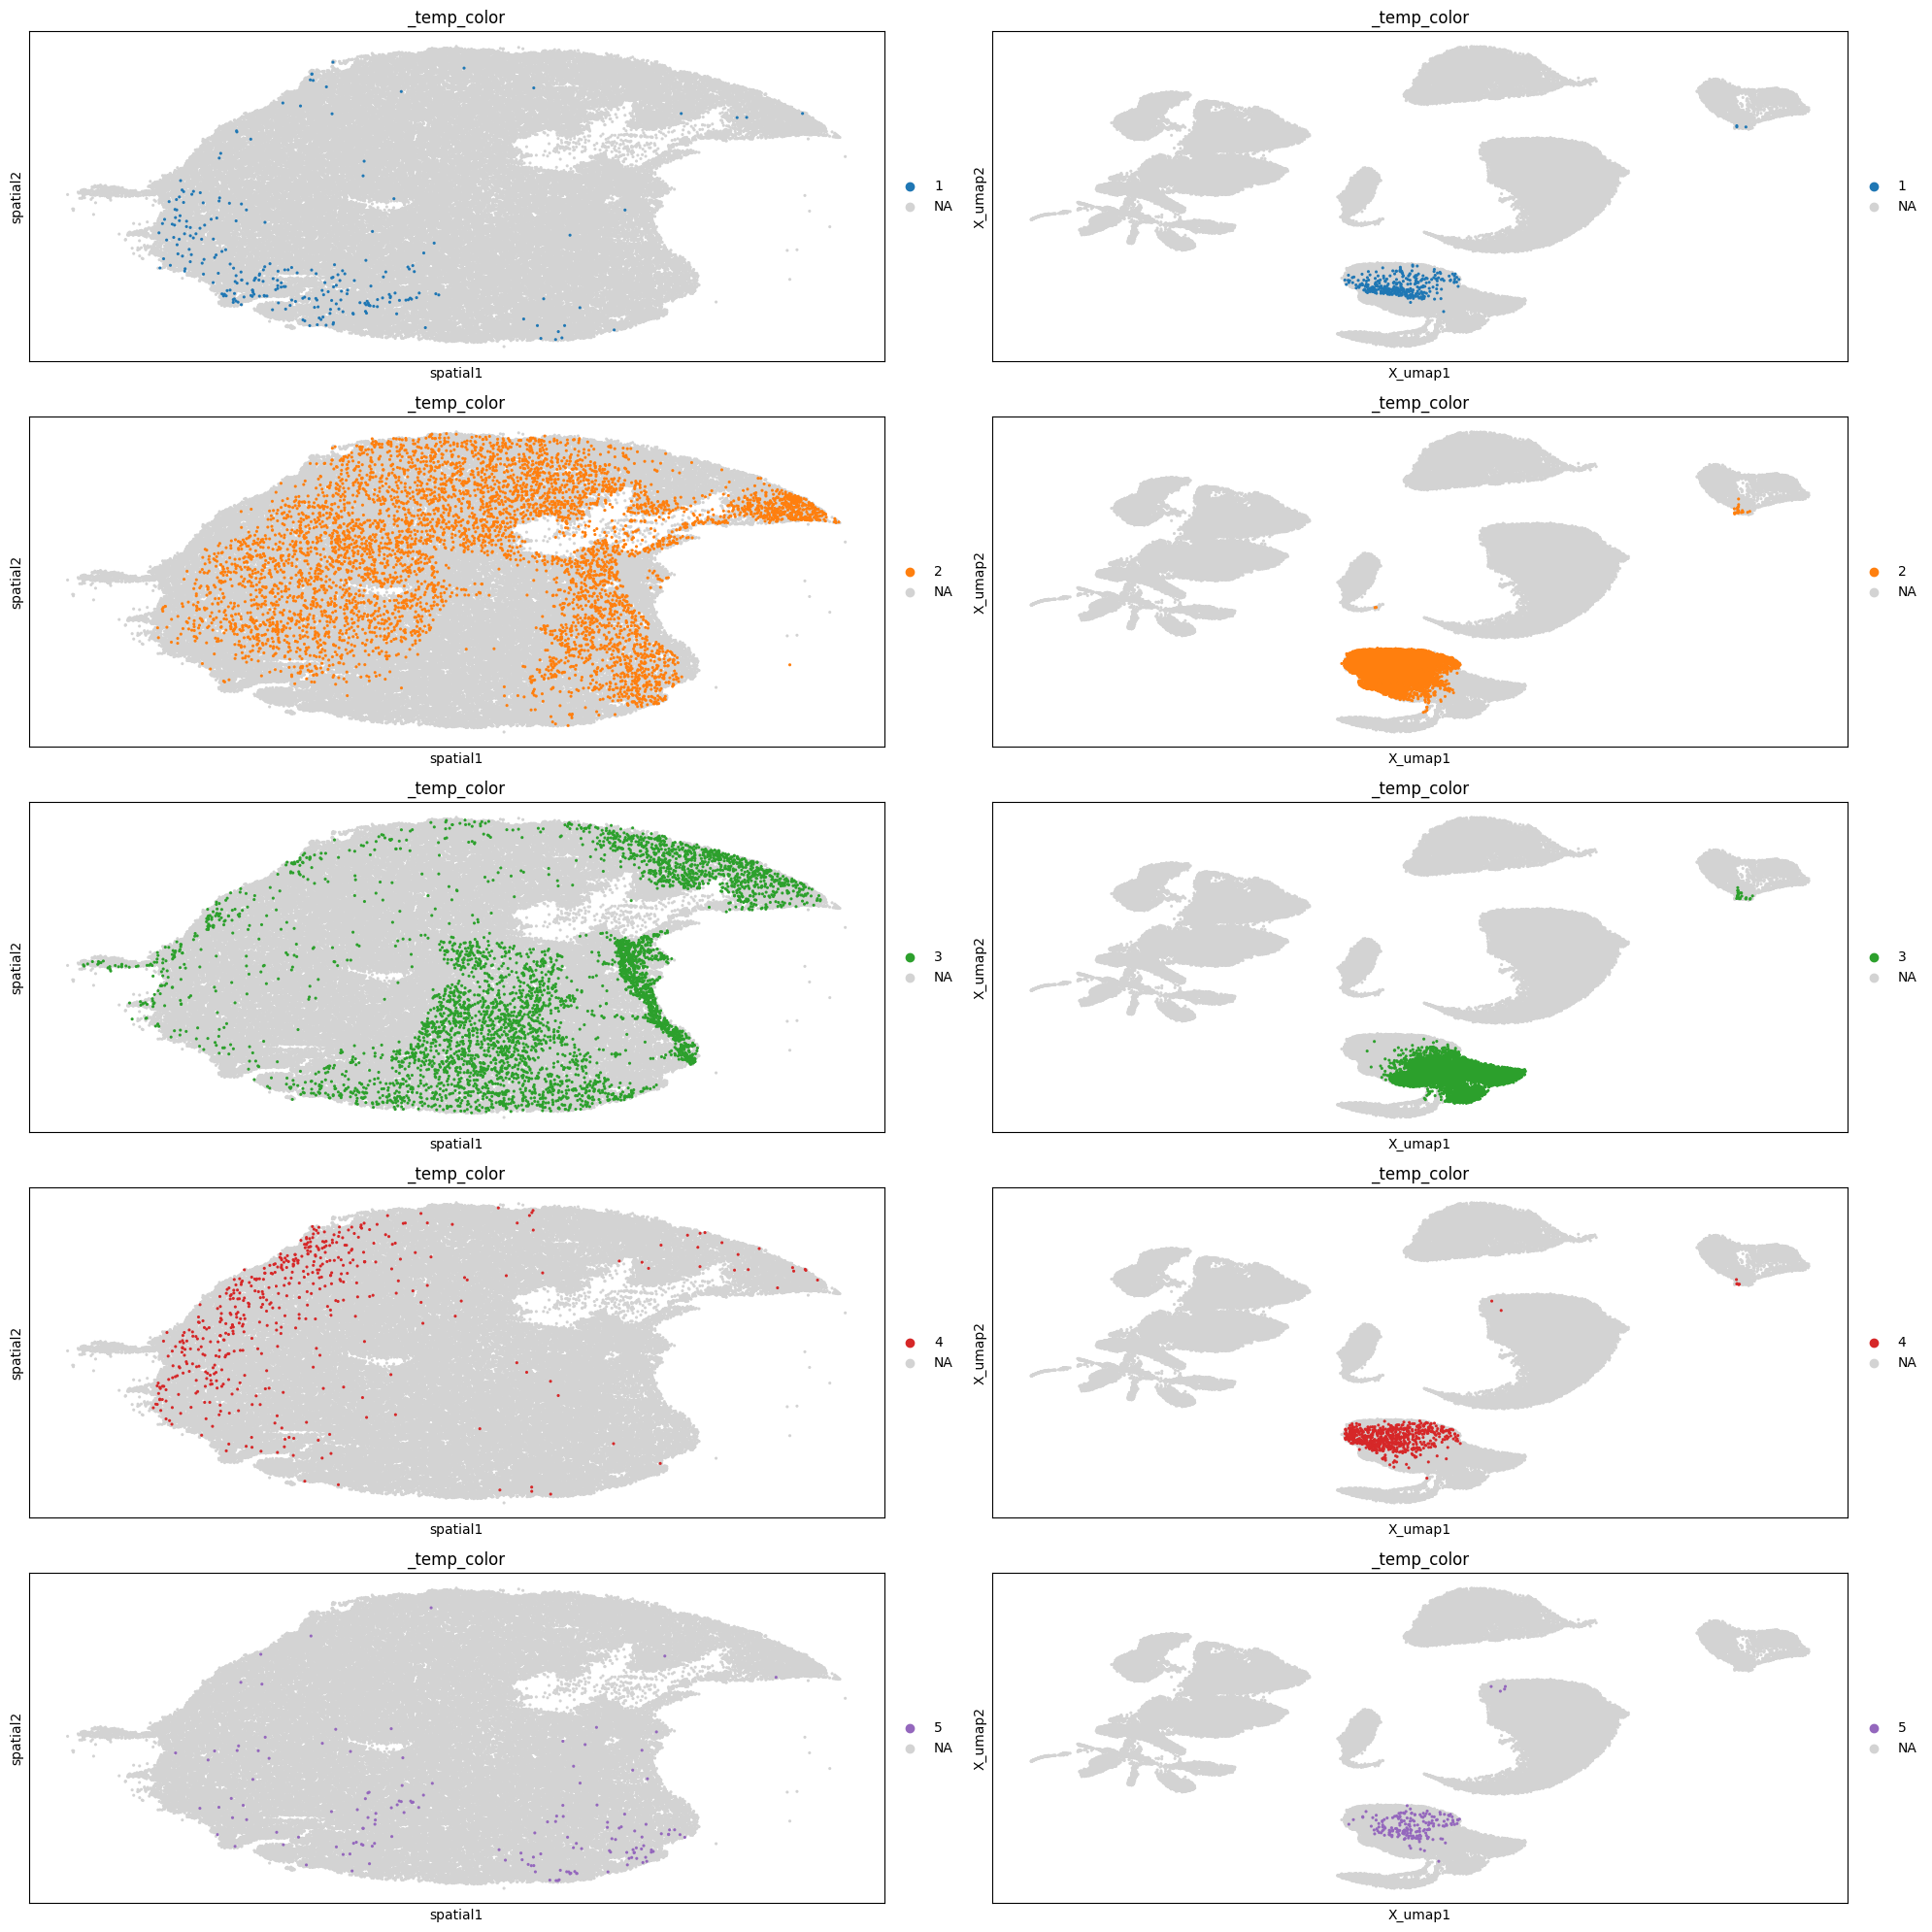

In [15]:
# Loop through each cell type
for CT_QUERY_NAME, CT_REFERENCE_NAME in CELL_TYPE_MAPPING.items():

    print(f"\n\n=== Mapping cell type: {CT_QUERY_NAME} using reference: {CT_REFERENCE_NAME} ===")

    # Subset to cells of interest
    print(f"\nSubsetting to {CT_QUERY_NAME} cells...")
    adata_ct = query[query.obs[CT_GROUPING_TO_MAP] == CT_QUERY_NAME].copy()
    print(f"  Found {adata_ct.n_obs} cells")

    # Get zones (remove NaN)
    zones = adata_ct.obs["zone"].dropna().sort_values().unique().tolist()

    if len(zones) == 0:
        print(f"No zones found for {CT_QUERY_NAME}. Skipping visualization.")
        continue

    # sc.pl.embedding(adata_ct, basis="spatial", color="zone", size=10, palette=palette)
    # sc.pl.embedding(adata_ct, basis="X_umap", color="zone", size=10, palette=palette)

    plot_celltype_colored(query, CT_GROUPING_TO_MAP, CT_QUERY_NAME, "zone", basis="spatial")#, ax=axes[0], show=False)
    plot_celltype_colored(query, CT_GROUPING_TO_MAP, CT_QUERY_NAME, "zone", basis="X_umap")#, ax=axes[0], show=False)


    # Plot each zone
    fig, axes = plt.subplots(len(zones), 2, figsize=(20, 4 * len(zones)))
    size=30

    for i, zone in enumerate(zones):

        # Plot
        # sc.pl.embedding(adata_ct, basis="spatial", color="zone", size=size, 
        #                 palette=palette, groups=[zone], ax=axes[i, 0], show=False)
        # sc.pl.umap(adata_ct, color="zone", size=size, palette=palette, 
        #             groups=[zone], ax=axes[i, 1], show=False)
        
        plot_celltype_colored(query, CT_GROUPING_TO_MAP, CT_QUERY_NAME, "zone", groups=[zone], basis="spatial", ax=axes[i, 0], show=False)
        plot_celltype_colored(query, CT_GROUPING_TO_MAP, CT_QUERY_NAME, "zone", groups=[zone], basis="X_umap", ax=axes[i, 1], show=False)


    plt.tight_layout()
    plt.show()


### Gene Markers zones

In [16]:

# zone_marker_genes_str = os.getenv("ZONE_MARKERS")
# zone_marker_genes = {int(k): v for k, v in json.loads(zone_marker_genes_str).items()}
# print(zone_marker_genes)

# sc.pl.umap(query_D1_matrix, color="zone", palette=palette)
# sc.pl.umap(query_D1_matrix, color="zone", palette=palette, groups=[1,2,6])


# preprocessing.calculate_and_plot_markers(query_D1_matrix, zone_marker_genes)

# Save Notebook

In [17]:
# Get the notebook path
notebook_path = str(ipynbname.path())
print(f"Current notebook: {notebook_path}")

# Save it
base_name = os.path.basename(notebook_path).replace('.ipynb', '')  # Remove .ipynb
saving_path = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/notebooks/{base_name}_{SAMPLE_ID}.ipynb"
print(f"Saved to {saving_path}")

print("\n   Press Ctrl+S")

Current notebook: /home/gdallagl/myworkdir/XDP/script/single_sample_analysis/06_zone_labelling.ipynb
Saved to /home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/notebooks/06_zone_labelling_recon_241105.ipynb

   Press Ctrl+S


In [18]:
shutil.copy(notebook_path, saving_path)

'/home/gdallagl/myworkdir/data/XDP/diseased/recon_241105/notebooks/06_zone_labelling_recon_241105.ipynb'